# Classification of dermatoscopic images

Dataset: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T

Source: Harvard Dataverse

Problem: classify pigmented skin lesions

Motivation: automatize the diagnostic from dermatoscopic images, without invasive and expensive interventions

Process’ summary:

1.	Metadata's exploration and description
    + Removal of the duplicates
2.	Images' pre-processing
    +  Reduction of the images' size
    +  Vectorization
    +  Consider the greyscale space
    +  Matrix
3.	Data partition and cross validation: training and test sets considering the balance of the classes
    +    Unbalanced problem    
4.	Supervised learning models
    + 	Random Forests with principal components
    + 	Neural Network
    + 	Convolutional Neural Networks
6.	Conclusions

Project done in group for the final delivery of the course **Introduction to Programming in Python** in the fall semester 2018 with two collegues, Sofia Jerónimo and Breno Morais.


***

# Introduction


* Abnormal lump, bump, ulcer, sore or coloured area on the skin.


* A correct diagnosis of the skin lesions are extremely important to start the correct treatment and prevent skin cancer.


* Earlier studies suffered from a small sample size and the lack of dermatoscopic images other than Melanoma or Melanocytic nevi.


* Seven types of skin lesions involved in this project:

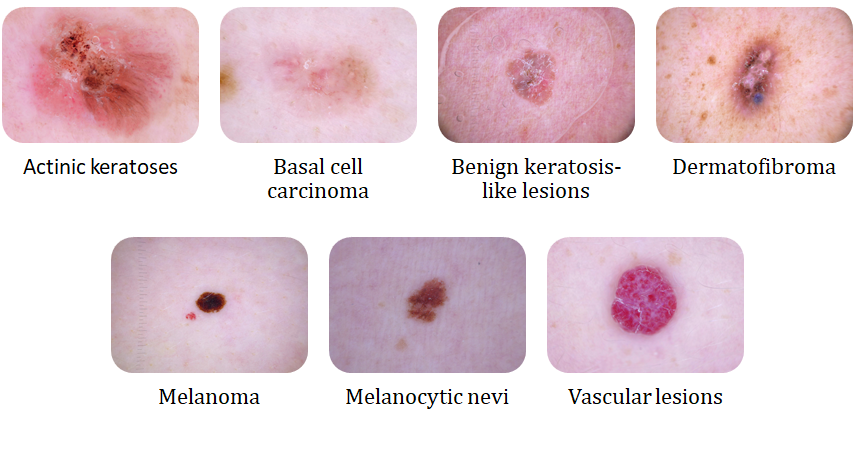



*** 

# 1. Exploration of the metadata

## General Overview

In [2]:
# Importing
import os, zipfile 
# ---
import csv
# ---
import numpy as np
import pandas as pd
import sys
import seaborn as sns
import imageio
import glob
# ---
from os import listdir
from os.path import isfile, join
import numpy as np
import imageio
# --- 
import imageio
import matplotlib.pyplot as plt
# ---
import scipy.ndimage as ndi
# ---
from skimage.color import rgb2gray
import skimage.io as io
# ---
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
# ---
from PIL import Image
import os
import sys
from skimage import color
# ---
import fnmatch
# ---
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# ---
from keras.models import Sequential
from sklearn.model_selection import train_test_split
# ---
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

C:\Users\bella\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#import metadata as panda dataframe: first row is the name of the columns, second column is the id of the images, lesions have more than one image
metadata = pd.read_csv('Metadata/HAM10000_metadata.csv', header=0, index_col=1)
print(metadata.head())
print(metadata.info()) #10015 images, 6 columns

                lesion_id   dx dx_type   age   sex localization
image_id                                                       
ISIC_0027419  HAM_0000118  bkl   histo  80.0  male        scalp
ISIC_0025030  HAM_0000118  bkl   histo  80.0  male        scalp
ISIC_0026769  HAM_0002730  bkl   histo  80.0  male        scalp
ISIC_0025661  HAM_0002730  bkl   histo  80.0  male        scalp
ISIC_0031633  HAM_0001466  bkl   histo  75.0  male          ear
<class 'pandas.core.frame.DataFrame'>
Index: 10015 entries, ISIC_0027419 to ISIC_0032258
Data columns (total 6 columns):
lesion_id       10015 non-null object
dx              10015 non-null object
dx_type         10015 non-null object
age             9958 non-null float64
sex             10015 non-null object
localization    10015 non-null object
dtypes: float64(1), object(5)
memory usage: 547.7+ KB
None


In [18]:
#counting the number of unique lesions
print("The number of unique lesions are:", len(metadata.lesion_id.value_counts()), "then there are", round(((10015-7470)/10015)*100, 3), "% of images that contains duplicated lesions.")
print("A lesion can be replicated for a maximum of", max(metadata.lesion_id.value_counts()), "times.")

#considering only unique lesions, then drop duplicates except for the first occurrence
metadatawithoutdup=metadata.drop_duplicates('lesion_id')

The number of unique lesions are: 7470 then there are 25.412 % of images that contains duplicated lesions.
A lesion can be replicated for a maximum of 6 times


## 1.1 Analysis of the skin lesions' types

In [89]:
print(len(metadata.dx.value_counts())) #7 classes
metadata.dx.unique() #notation

7


array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

**bkl** = Benign keratosis-like lesion

**nv** = Melanocytic nevi

**df** = Dermatofribroma

**mel** = Melanoma

**vasc** = Vascular lesion

**bcc** = Basal cell carcinoma

**akiec** = Actinic keratoses


Count         count
Lesion types       
akiec           327
bcc             514
bkl            1099
df              115
mel            1113
nv             6705
vasc            142
Percentage      count
Lesion types         
akiec          3.2651
bcc            5.1323
bkl           10.9735
df             1.1483
mel           11.1133
nv            66.9496
vasc           1.4179


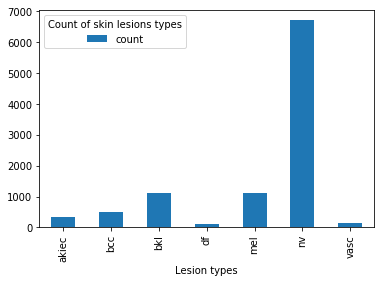

In [80]:
#classes with duplicates
tab_original=pd.crosstab(index=metadata["dx"], columns="count", rownames=['Lesion types'], colnames=['Count'])
print(tab_original)
#perc_original=(tab_original/tab_original.sum())*100
perc_original_1=round(pd.crosstab(index=metadata["dx"], columns="count", normalize="all", rownames=['Lesion types'], colnames=['Percentage']), 6)*100
print(perc_original_1) #melanoma and nevi most frequent as literature review suggested

tab_original.plot.bar()
plt.legend(title='Count of skin lesions types')
plt.show()

col_0  count
dx          
akiec    228
bcc      327
bkl      727
df        73
mel      614
nv      5403
vasc      98
Percentage      count
Lesion types         
akiec          3.0522
bcc            4.3775
bkl            9.7323
df             0.9772
mel            8.2195
nv            72.3293
vasc           1.3119


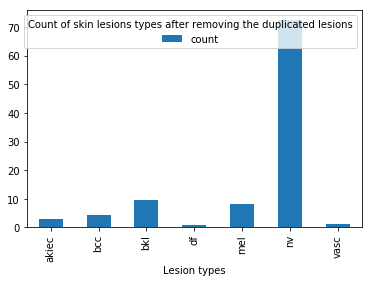

In [81]:
#classes without duplicates
tab_uniqueles=pd.crosstab(index=metadatawithoutdup["dx"], columns="count")
print(tab_uniqueles)
#percentage
perc_tab_uniqueles=round(pd.crosstab(index=metadatawithoutdup["dx"], columns="count", normalize="all", rownames=['Lesion types'], colnames=['Percentage']), 6)*100
print(perc_tab_uniqueles)  #bkl > mel

perc_tab_uniqueles.plot.bar()
plt.legend(title='Count of skin lesions types after removing the duplicated lesions')
plt.show()

In [82]:
#differences of the classes before and after droping the duplicates
print(tab_uniqueles-tab_original)
before_after=((tab_uniqueles-tab_original)/tab_original)*100
print(before_after) #melanoma almost halved

col_0  count
dx          
akiec    -99
bcc     -187
bkl     -372
df       -42
mel     -499
nv     -1302
vasc     -44
col_0      count
dx              
akiec -30.275229
bcc   -36.381323
bkl   -33.848954
df    -36.521739
mel   -44.833783
nv    -19.418345
vasc  -30.985915


## 1.2 Analysis of diagnosis' ways

In [91]:
#Considering the dx_type (diagnosis way): more than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal).
print(len(metadata.dx_type.value_counts())) #4 diagnosis types
metadata.dx_type.unique() #notation

4


array(['histo', 'consensus', 'confocal', 'follow_up'], dtype=object)

**histo** = histopathology

**follow_up** = follow-up examination

**consensus** = expert consensus

**confocal** = in-vivo confocal microscopy

Count             count
Confirmation way       
confocal             69
consensus           902
follow_up          3704
histo              5340
Percentage          count
Confirmation way         
confocal           0.6890
consensus          9.0065
follow_up         36.9845
histo             53.3200


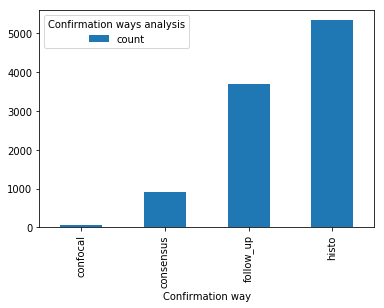

In [105]:
#with duplicates
tab_original=pd.crosstab(index=metadata["dx_type"], columns="count", rownames=['Confirmation way'], colnames=['Count'])
print(tab_original)
perc_original_1=round(pd.crosstab(index=metadata["dx_type"], columns="count", normalize="all", rownames=['Confirmation way'], colnames=['Percentage']), 6)*100
print(perc_original_1) #more than >50% confirmed by histopathology

tab_original.plot.bar()
plt.legend(title='Confirmation ways analysis')
plt.show()

dx         akiec  bcc   bkl   df   mel    nv  vasc    All
dx_type                                                  
confocal       0    0    69    0     0     0     0     69
consensus      0    0   264   60     0   503    75    902
follow_up      0    0     0    0     0  3704     0   3704
histo        327  514   766   55  1113  2498    67   5340
All          327  514  1099  115  1113  6705   142  10015
dx          akiec     bcc      bkl      df      mel       nv    vasc       All
dx_type                                                                       
confocal   0.0000  0.0000   0.6890  0.0000   0.0000   0.0000  0.0000    0.6890
consensus  0.0000  0.0000   2.6360  0.5991   0.0000   5.0225  0.7489    9.0065
follow_up  0.0000  0.0000   0.0000  0.0000   0.0000  36.9845  0.0000   36.9845
histo      3.2651  5.1323   7.6485  0.5492  11.1133  24.9426  0.6690   53.3200
All        3.2651  5.1323  10.9735  1.1483  11.1133  66.9496  1.4179  100.0000


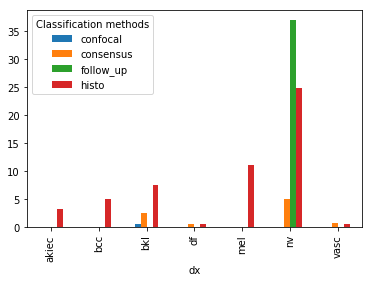

In [109]:
#with duplicates, considering how the different classes are classified
ways=pd.crosstab(metadata.dx_type, metadata.dx,margins=True)
print(ways)

perc_way=round(pd.crosstab(metadata.dx_type, metadata.dx,margins=True, normalize="all"), 6)*100
print(perc_way)
#ax = sns.countplot(x="dx_type",hue="dx", data=metadata)

perc_way1=round(pd.crosstab(metadata.dx, metadata.dx_type, normalize="all"), 6)*100
perc_way1.plot.bar()
plt.legend(title='Classification methods')
plt.show()

#followup happens with nv
#confocal with bkl
#consensus with bkl, df, nv and vasc

Count             count
Confirmation way       
confocal             34
consensus           647
follow_up          3704
histo              3085
Percentage          count
Confirmation way         
confocal           0.4552
consensus          8.6613
follow_up         49.5850
histo             41.2985


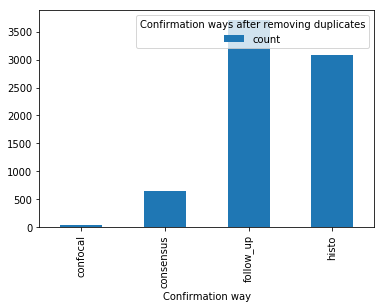

In [114]:
#without duplicates
tab_uniqueles=pd.crosstab(index=metadatawithoutdup["dx_type"], columns="count", rownames=['Confirmation way'], colnames=['Count'])
print(tab_uniqueles)
perc_uniqueles_1=round(pd.crosstab(index=metadatawithoutdup["dx_type"], columns="count", normalize="all", rownames=['Confirmation way'], colnames=['Percentage']), 6)*100
print(perc_uniqueles_1)  #follow up more than histo removing the duplicates

tab_uniqueles.plot.bar()
plt.legend(title='Confirmation ways after removing duplicates')
plt.show()

In [151]:
#checking if the duplicates are because of more than one dx_type
print(metadata.head())
groupbylesionID=metadata.groupby('lesion_id')['dx_type'].count()
groupbylesionID_df=pd.Series.to_frame(groupbylesionID)
print(groupbylesionID_df.info()) #7470
diff_dxtype=groupbylesionID_df[groupbylesionID_df.dx_type >1]
print(diff_dxtype.info()) #1956
10015-7470 #2545
(1956/2545)*100 #76.86% of the cases are duplicated because they change the way how the lesion is classified.

                lesion_id   dx dx_type   age   sex localization
image_id                                                       
ISIC_0027419  HAM_0000118  bkl   histo  80.0  male        scalp
ISIC_0025030  HAM_0000118  bkl   histo  80.0  male        scalp
ISIC_0026769  HAM_0002730  bkl   histo  80.0  male        scalp
ISIC_0025661  HAM_0002730  bkl   histo  80.0  male        scalp
ISIC_0031633  HAM_0001466  bkl   histo  75.0  male          ear
<class 'pandas.core.frame.DataFrame'>
Index: 7470 entries, HAM_0000000 to HAM_0007628
Data columns (total 1 columns):
dx_type    7470 non-null int64
dtypes: int64(1)
memory usage: 116.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1956 entries, HAM_0000000 to HAM_0007627
Data columns (total 1 columns):
dx_type    1956 non-null int64
dtypes: int64(1)
memory usage: 30.6+ KB
None


76.8565815324165

dx         akiec  bcc  bkl  df  mel    nv  vasc   All
dx_type                                              
confocal       0    0   34   0    0     0     0    34
consensus      0    0  206  44    0   332    65   647
follow_up      0    0    0   0    0  3704     0  3704
histo        228  327  487  29  614  1367    33  3085
All          228  327  727  73  614  5403    98  7470
dx          akiec     bcc     bkl      df     mel       nv    vasc       All
dx_type                                                                     
confocal   0.0000  0.0000  0.4552  0.0000  0.0000   0.0000  0.0000    0.4552
consensus  0.0000  0.0000  2.7577  0.5890  0.0000   4.4444  0.8701    8.6613
follow_up  0.0000  0.0000  0.0000  0.0000  0.0000  49.5850  0.0000   49.5850
histo      3.0522  4.3775  6.5194  0.3882  8.2195  18.2999  0.4418   41.2985
All        3.0522  4.3775  9.7323  0.9772  8.2195  72.3293  1.3119  100.0000


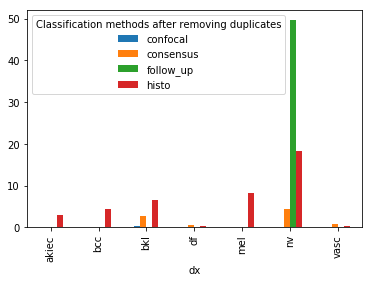

In [152]:
#without duplicates, considering how the different classes are classified
#with duplicates, 
ways=pd.crosstab(metadatawithoutdup.dx_type, metadatawithoutdup.dx,margins=True)
print(ways)

perc_way=round(pd.crosstab(metadatawithoutdup.dx_type, metadatawithoutdup.dx,margins=True, normalize="all"), 6)*100
print(perc_way)
#ax = sns.countplot(x="dx_type",hue="dx", data=metadata)

perc_way1=round(pd.crosstab(metadatawithoutdup.dx, metadatawithoutdup.dx_type, normalize="all"), 6)*100
perc_way1.plot.bar()
plt.legend(title='Classification methods after removing duplicates')
plt.show()

#before dropping the duplicates = after droppung the duplicates considering the classes
#followup happens with nv
#confocal with bkl
#consensus with bkl, df, nv and vasc

## 1.3 Analysis of the age

               age
count  7418.000000
mean     51.658803
std      16.016472
min       0.000000
25%      40.000000
50%      50.000000
75%      65.000000
max      85.000000


C:\Users\bella\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\bella\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0,0.5,'Density')

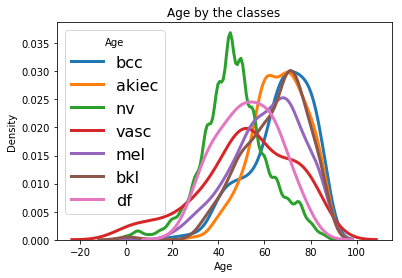

In [156]:
# Considering unique lesions id
print(metadatawithoutdup.describe())
#print(metadatawithoutdup.info())
#print(((7470-7418)/7470)*100)
#study of the age by type
#print(set(metadatawithoutdup.dx)) #return the classes
classes=['bcc', 'akiec', 'nv', 'vasc', 'mel', 'bkl', 'df']

metadata1=metadatawithoutdup
metadata1['age'].dropna() 

# Iterate through the 7 classes
for clas in classes:
    # Subset to the class
    subset = metadata1[metadata1['dx'] == clas]
    
    # Draw the density plot
    sns.distplot(subset['age'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = clas)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Classes')
plt.title('Age by the classes')
plt.xlabel('Age')
plt.ylabel('Density')

## 1.4 Analysis of the sex

dx       akiec  bcc  bkl  df  mel    nv  vasc   All
sex                                                
female      80  122  304  38  243  2584    48  3419
male       148  205  414  35  371  2778    50  4001
unknown      0    0    9   0    0    41     0    50
All        228  327  727  73  614  5403    98  7470
dx        akiec     bcc     bkl      df     mel       nv    vasc       All
sex                                                                       
female   1.0710  1.6332  4.0696  0.5087  3.2530  34.5917  0.6426   45.7697
male     1.9813  2.7443  5.5422  0.4685  4.9665  37.1888  0.6693   53.5609
unknown  0.0000  0.0000  0.1205  0.0000  0.0000   0.5489  0.0000    0.6693
All      3.0522  4.3775  9.7323  0.9772  8.2195  72.3293  1.3119  100.0000


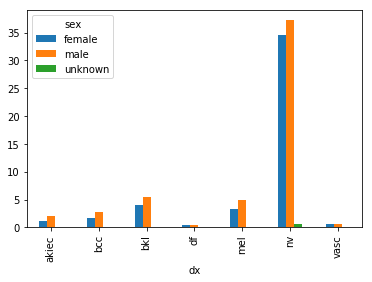

In [158]:
# Considering unique lesions id
sex=pd.crosstab(metadatawithoutdup.sex, metadatawithoutdup.dx,margins=True)
print(sex)

perc_sex=round(pd.crosstab(metadatawithoutdup.sex, metadatawithoutdup.dx,margins=True, normalize="all"), 6)*100
print(perc_sex)

perc_sex1=round(pd.crosstab(metadatawithoutdup.dx, metadatawithoutdup.sex, normalize="all"), 6)*100
perc_sex1.plot.bar()
plt.show()

***

## 1.5 Analysis of the localization

In [159]:
print(len(metadatawithoutdup.localization.value_counts())) #15 localizations
metadatawithoutdup.localization.unique() #notation

15


array(['scalp', 'ear', 'face', 'back', 'trunk', 'chest',
       'upper extremity', 'abdomen', 'unknown', 'lower extremity',
       'genital', 'neck', 'hand', 'foot', 'acral'], dtype=object)

dx               akiec  bcc  bkl  df  mel    nv  vasc   All
localization                                               
abdomen              3    9   36   2   31   719    22   822
acral                0    0    0   0    0     3     0     3
back                22  123  133   1  185  1058    12  1534
chest                9   32   50   0   34   112     3   240
ear                  2    0    4   0   10    19     0    35
face                84   61  194   0   65    61     5   470
foot                 0    2    1   1   15   209     0   228
genital              0    0    1   1    0    43     0    45
hand                 8    1   12   0    1    39     3    64
lower extremity     41   36  109  54  104  1224    16  1584
neck                 8   11   20   0   18    60     2   119
scalp                8   11   24   0    9    24     2    78
trunk                1    6   57   0   25  1153    27  1269
unknown              0    3   19   0    6   175     0   203
upper extremity     42   32   67  14  11

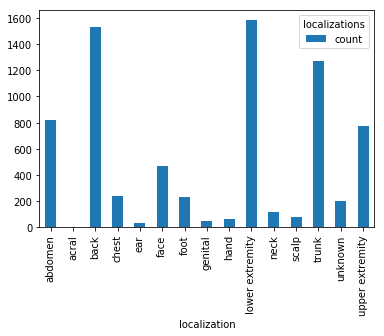

In [165]:
loc=pd.crosstab(metadatawithoutdup.localization, metadatawithoutdup.dx,margins=True)
print(loc)

perc_loc=round(pd.crosstab(metadatawithoutdup.localization, metadatawithoutdup.dx,margins=True, normalize="all"), 6)*100
print(perc_loc)
#ax = sns.countplot(x="dx_type",hue="dx", data=metadata)
#perc_loc1=round(pd.crosstab(metadatawithoutdup.dx, metadatawithoutdup.localization,normalize="all"), 6)*100
#perc_loc1.plot.bar()
#plt.show()
tab_uniqueles=pd.crosstab(index=metadatawithoutdup["localization"], columns="count", rownames=['localization'], colnames=['Count'])
print(tab_uniqueles)
tab_uniqueles.plot.bar()
plt.legend(title='localizations')
plt.show()

***

 # 2. Images' pre-processing

## 2.1 Extraction of the images and removal of duplicated lesions ID

In [3]:
#Seting the directory for the images 
dir_zip_files = 'C:/Users/bella/OneDrive/Desktop/github_repositories/Classification_skinlesion_images_Py/zipFiles/'
dir_unzip_files = 'C:/Users/bella/OneDrive/Desktop/github_repositories/Classification_skinlesion_images_Py/DataBase/'

In [183]:
# #Extracting All Files From the Ziz File
extension = ".zip"
os.chdir(dir_zip_files) # change directory from working dir to dir with files

# # Loop to extract all Images from a the zip file on directory
for item in os.listdir(dir_zip_files): # loop through items in dir
    if item.endswith(extension): # check for ".zip" extension
        file_name = os.path.abspath(item) # get full path of files
        print("Processing %s" % file_name)
        zip_ref = zipfile.ZipFile(file_name) # create zipfile object
        os.chdir(dir_zip_files) # change directory from working dir to dir with files
        zip_ref.extractall(dir_unzip_files) # extract file to dir
        zip_ref.close() # close file
        os.remove(file_name) # delete zipped file

None
Processing C:\Users\bella\OneDrive\Desktop\github_repositories\Classification_skinlesion_images_Py\zipFiles\HAM10000_images_part_1.zip
Processing C:\Users\bella\OneDrive\Desktop\github_repositories\Classification_skinlesion_images_Py\zipFiles\HAM10000_images_part_2.zip


In [186]:
# # Reading the the file names of the each image
filenames = [os.path.splitext(filename)[0] for filename in os.listdir(dir_unzip_files) if filename.startswith("ISIC_")]
filenames = pd.DataFrame(np.array(filenames).reshape(10015,1),columns=['filenames'])
filenames.head()

metadata.head()

,lesion_id,dx,dx_type,age,sex,localization
image_id,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear


In [188]:
# # Merging the file names and the metadata, thus organizing the data.
organized_metadata = pd.merge(left=filenames, right=metadata, left_on='filenames',right_on='image_id')
organized_metadata.head()

,filenames,lesion_id,dx,dx_type,age,sex,localization
0,ISIC_0024306,HAM_0000550,nv,follow_up,45.0,male,trunk
1,ISIC_0024307,HAM_0003577,nv,follow_up,50.0,male,lower extremity
2,ISIC_0024308,HAM_0001477,nv,follow_up,55.0,female,trunk
3,ISIC_0024309,HAM_0000484,nv,follow_up,40.0,male,trunk
4,ISIC_0024310,HAM_0003350,mel,histo,60.0,male,chest


In [189]:
# # Creating list with duplicate files
repeated_images = organized_metadata[organized_metadata["lesion_id"].duplicated()]
repeated_images.to_csv('C:/Users/bella/OneDrive/Desktop/github_repositories/Classification_skinlesion_images_Py/repeated_images.csv')
repeated_images = repeated_images['filenames']

organized_metadata = organized_metadata.drop_duplicates(subset=['lesion_id'],keep="first")
organized_metadata.to_csv('C:/Users/bella/OneDrive/Desktop/github_repositories/Classification_skinlesion_images_Py/organized_metadata.csv')

unique_images = organized_metadata['filenames'] 
unique_images.to_csv('C:/Users/bella/OneDrive/Desktop/github_repositories/Classification_skinlesion_images_Py/unique_images.csv') 

In [190]:
#removing the duplicated lesions
repeated_images_star = repeated_images + '.jpg'
os.chdir('C:/Users/bella/OneDrive/Desktop/github_repositories/Classification_skinlesion_images_Py/DataBase')
for filename in repeated_images_star:
     os.remove(filename)

In [5]:
# Arranging the files and metadata again
# Reading the the file names of the each image
filenames = [os.path.splitext(filename)[0] for filename in os.listdir(dir_unzip_files) if filename.startswith("ISIC_")]
filenames = pd.DataFrame(np.array(filenames).reshape(7470,1),columns=['filenames'])

# Merging the file names and the metadata, thus organizing the data.
organized_metadata = pd.merge(left=filenames, right=metadata, left_on='filenames',right_on='image_id')
#organized_metadata
organized_metadata.to_csv("C:/Users/bella/OneDrive/Desktop/github_repositories/Classification_skinlesion_images_Py/organized_metadata.csv")

## 2.2 Size's reduction

In [199]:
# # Decreasing the size of images (Resized_rgb)
# # From 600X450 to 200X150: 1/3 of the original
path = dir_unzip_files
dirs = os.listdir( path )

for file_name in os.listdir(path):
    print("Processing %s" % file_name)
    image = Image.open(os.path.join(path, file_name))
    x,y = image.size
    new_dimensions = (200, 150)
    output = image.resize(new_dimensions, Image.ANTIALIAS) #a high-quality downsampling filter
    output_file_name = os.path.join(path, "small_" + file_name)
    output.save(output_file_name, "JPEG", quality = 95)

Processing ISIC_0024306.jpg
Processing ISIC_0024307.jpg
Processing ISIC_0024308.jpg
Processing ISIC_0024309.jpg
Processing ISIC_0024310.jpg
Processing ISIC_0024311.jpg
Processing ISIC_0024312.jpg
Processing ISIC_0024313.jpg
Processing ISIC_0024314.jpg
Processing ISIC_0024315.jpg
Processing ISIC_0024316.jpg
Processing ISIC_0024317.jpg
Processing ISIC_0024318.jpg
Processing ISIC_0024319.jpg
Processing ISIC_0024320.jpg
Processing ISIC_0024321.jpg
Processing ISIC_0024322.jpg
Processing ISIC_0024323.jpg
Processing ISIC_0024324.jpg
Processing ISIC_0024325.jpg
Processing ISIC_0024326.jpg
Processing ISIC_0024327.jpg
Processing ISIC_0024328.jpg
Processing ISIC_0024329.jpg
Processing ISIC_0024330.jpg
Processing ISIC_0024331.jpg
Processing ISIC_0024332.jpg
Processing ISIC_0024333.jpg
Processing ISIC_0024334.jpg
Processing ISIC_0024335.jpg
Processing ISIC_0024336.jpg
Processing ISIC_0024337.jpg
Processing ISIC_0024338.jpg
Processing ISIC_0024339.jpg
Processing ISIC_0024340.jpg
Processing ISIC_0024

Processing ISIC_0024898.jpg
Processing ISIC_0024899.jpg
Processing ISIC_0024900.jpg
Processing ISIC_0024901.jpg
Processing ISIC_0024902.jpg
Processing ISIC_0024903.jpg
Processing ISIC_0024904.jpg
Processing ISIC_0024905.jpg
Processing ISIC_0024906.jpg
Processing ISIC_0024907.jpg
Processing ISIC_0024908.jpg
Processing ISIC_0024909.jpg
Processing ISIC_0024910.jpg
Processing ISIC_0024911.jpg
Processing ISIC_0024912.jpg
Processing ISIC_0024913.jpg
Processing ISIC_0024914.jpg
Processing ISIC_0024915.jpg
Processing ISIC_0024916.jpg
Processing ISIC_0024917.jpg
Processing ISIC_0024919.jpg
Processing ISIC_0024920.jpg
Processing ISIC_0024921.jpg
Processing ISIC_0024922.jpg
Processing ISIC_0024923.jpg
Processing ISIC_0024924.jpg
Processing ISIC_0024925.jpg
Processing ISIC_0024926.jpg
Processing ISIC_0024927.jpg
Processing ISIC_0024928.jpg
Processing ISIC_0024929.jpg
Processing ISIC_0024930.jpg
Processing ISIC_0024931.jpg
Processing ISIC_0024932.jpg
Processing ISIC_0024933.jpg
Processing ISIC_0024

Processing ISIC_0025207.jpg
Processing ISIC_0025209.jpg
Processing ISIC_0025210.jpg
Processing ISIC_0025211.jpg
Processing ISIC_0025212.jpg
Processing ISIC_0025213.jpg
Processing ISIC_0025214.jpg
Processing ISIC_0025215.jpg
Processing ISIC_0025216.jpg
Processing ISIC_0025217.jpg
Processing ISIC_0025218.jpg
Processing ISIC_0025219.jpg
Processing ISIC_0025220.jpg
Processing ISIC_0025221.jpg
Processing ISIC_0025222.jpg
Processing ISIC_0025223.jpg
Processing ISIC_0025224.jpg
Processing ISIC_0025225.jpg
Processing ISIC_0025226.jpg
Processing ISIC_0025227.jpg
Processing ISIC_0025228.jpg
Processing ISIC_0025229.jpg
Processing ISIC_0025230.jpg
Processing ISIC_0025232.jpg
Processing ISIC_0025233.jpg
Processing ISIC_0025234.jpg
Processing ISIC_0025235.jpg
Processing ISIC_0025236.jpg
Processing ISIC_0025237.jpg
Processing ISIC_0025238.jpg
Processing ISIC_0025239.jpg
Processing ISIC_0025240.jpg
Processing ISIC_0025241.jpg
Processing ISIC_0025242.jpg
Processing ISIC_0025243.jpg
Processing ISIC_0025

Processing ISIC_0025525.jpg
Processing ISIC_0025526.jpg
Processing ISIC_0025527.jpg
Processing ISIC_0025528.jpg
Processing ISIC_0025529.jpg
Processing ISIC_0025531.jpg
Processing ISIC_0025532.jpg
Processing ISIC_0025533.jpg
Processing ISIC_0025534.jpg
Processing ISIC_0025535.jpg
Processing ISIC_0025536.jpg
Processing ISIC_0025537.jpg
Processing ISIC_0025538.jpg
Processing ISIC_0025539.jpg
Processing ISIC_0025540.jpg
Processing ISIC_0025542.jpg
Processing ISIC_0025543.jpg
Processing ISIC_0025544.jpg
Processing ISIC_0025545.jpg
Processing ISIC_0025546.jpg
Processing ISIC_0025547.jpg
Processing ISIC_0025548.jpg
Processing ISIC_0025549.jpg
Processing ISIC_0025551.jpg
Processing ISIC_0025552.jpg
Processing ISIC_0025553.jpg
Processing ISIC_0025556.jpg
Processing ISIC_0025557.jpg
Processing ISIC_0025558.jpg
Processing ISIC_0025559.jpg
Processing ISIC_0025560.jpg
Processing ISIC_0025561.jpg
Processing ISIC_0025562.jpg
Processing ISIC_0025563.jpg
Processing ISIC_0025564.jpg
Processing ISIC_0025

Processing ISIC_0025841.jpg
Processing ISIC_0025842.jpg
Processing ISIC_0025843.jpg
Processing ISIC_0025844.jpg
Processing ISIC_0025845.jpg
Processing ISIC_0025846.jpg
Processing ISIC_0025847.jpg
Processing ISIC_0025848.jpg
Processing ISIC_0025849.jpg
Processing ISIC_0025850.jpg
Processing ISIC_0025851.jpg
Processing ISIC_0025852.jpg
Processing ISIC_0025853.jpg
Processing ISIC_0025854.jpg
Processing ISIC_0025855.jpg
Processing ISIC_0025856.jpg
Processing ISIC_0025857.jpg
Processing ISIC_0025858.jpg
Processing ISIC_0025859.jpg
Processing ISIC_0025861.jpg
Processing ISIC_0025862.jpg
Processing ISIC_0025864.jpg
Processing ISIC_0025866.jpg
Processing ISIC_0025867.jpg
Processing ISIC_0025868.jpg
Processing ISIC_0025870.jpg
Processing ISIC_0025871.jpg
Processing ISIC_0025872.jpg
Processing ISIC_0025873.jpg
Processing ISIC_0025874.jpg
Processing ISIC_0025875.jpg
Processing ISIC_0025876.jpg
Processing ISIC_0025877.jpg
Processing ISIC_0025878.jpg
Processing ISIC_0025879.jpg
Processing ISIC_0025

Processing ISIC_0026178.jpg
Processing ISIC_0026179.jpg
Processing ISIC_0026180.jpg
Processing ISIC_0026181.jpg
Processing ISIC_0026183.jpg
Processing ISIC_0026184.jpg
Processing ISIC_0026185.jpg
Processing ISIC_0026187.jpg
Processing ISIC_0026188.jpg
Processing ISIC_0026189.jpg
Processing ISIC_0026191.jpg
Processing ISIC_0026192.jpg
Processing ISIC_0026193.jpg
Processing ISIC_0026194.jpg
Processing ISIC_0026195.jpg
Processing ISIC_0026196.jpg
Processing ISIC_0026197.jpg
Processing ISIC_0026198.jpg
Processing ISIC_0026199.jpg
Processing ISIC_0026200.jpg
Processing ISIC_0026201.jpg
Processing ISIC_0026202.jpg
Processing ISIC_0026203.jpg
Processing ISIC_0026204.jpg
Processing ISIC_0026205.jpg
Processing ISIC_0026206.jpg
Processing ISIC_0026207.jpg
Processing ISIC_0026208.jpg
Processing ISIC_0026209.jpg
Processing ISIC_0026211.jpg
Processing ISIC_0026212.jpg
Processing ISIC_0026213.jpg
Processing ISIC_0026214.jpg
Processing ISIC_0026215.jpg
Processing ISIC_0026217.jpg
Processing ISIC_0026

Processing ISIC_0026523.jpg
Processing ISIC_0026525.jpg
Processing ISIC_0026526.jpg
Processing ISIC_0026527.jpg
Processing ISIC_0026528.jpg
Processing ISIC_0026529.jpg
Processing ISIC_0026531.jpg
Processing ISIC_0026532.jpg
Processing ISIC_0026533.jpg
Processing ISIC_0026534.jpg
Processing ISIC_0026535.jpg
Processing ISIC_0026536.jpg
Processing ISIC_0026537.jpg
Processing ISIC_0026538.jpg
Processing ISIC_0026540.jpg
Processing ISIC_0026541.jpg
Processing ISIC_0026542.jpg
Processing ISIC_0026543.jpg
Processing ISIC_0026544.jpg
Processing ISIC_0026545.jpg
Processing ISIC_0026546.jpg
Processing ISIC_0026547.jpg
Processing ISIC_0026548.jpg
Processing ISIC_0026549.jpg
Processing ISIC_0026550.jpg
Processing ISIC_0026552.jpg
Processing ISIC_0026553.jpg
Processing ISIC_0026554.jpg
Processing ISIC_0026555.jpg
Processing ISIC_0026556.jpg
Processing ISIC_0026557.jpg
Processing ISIC_0026558.jpg
Processing ISIC_0026559.jpg
Processing ISIC_0026561.jpg
Processing ISIC_0026562.jpg
Processing ISIC_0026

Processing ISIC_0026858.jpg
Processing ISIC_0026859.jpg
Processing ISIC_0026860.jpg
Processing ISIC_0026861.jpg
Processing ISIC_0026862.jpg
Processing ISIC_0026863.jpg
Processing ISIC_0026864.jpg
Processing ISIC_0026865.jpg
Processing ISIC_0026867.jpg
Processing ISIC_0026868.jpg
Processing ISIC_0026870.jpg
Processing ISIC_0026871.jpg
Processing ISIC_0026872.jpg
Processing ISIC_0026873.jpg
Processing ISIC_0026874.jpg
Processing ISIC_0026875.jpg
Processing ISIC_0026876.jpg
Processing ISIC_0026877.jpg
Processing ISIC_0026878.jpg
Processing ISIC_0026879.jpg
Processing ISIC_0026880.jpg
Processing ISIC_0026881.jpg
Processing ISIC_0026882.jpg
Processing ISIC_0026883.jpg
Processing ISIC_0026884.jpg
Processing ISIC_0026885.jpg
Processing ISIC_0026886.jpg
Processing ISIC_0026888.jpg
Processing ISIC_0026889.jpg
Processing ISIC_0026891.jpg
Processing ISIC_0026893.jpg
Processing ISIC_0026894.jpg
Processing ISIC_0026895.jpg
Processing ISIC_0026896.jpg
Processing ISIC_0026897.jpg
Processing ISIC_0026

Processing ISIC_0027195.jpg
Processing ISIC_0027196.jpg
Processing ISIC_0027197.jpg
Processing ISIC_0027199.jpg
Processing ISIC_0027200.jpg
Processing ISIC_0027201.jpg
Processing ISIC_0027202.jpg
Processing ISIC_0027203.jpg
Processing ISIC_0027204.jpg
Processing ISIC_0027205.jpg
Processing ISIC_0027206.jpg
Processing ISIC_0027207.jpg
Processing ISIC_0027208.jpg
Processing ISIC_0027209.jpg
Processing ISIC_0027211.jpg
Processing ISIC_0027212.jpg
Processing ISIC_0027213.jpg
Processing ISIC_0027214.jpg
Processing ISIC_0027215.jpg
Processing ISIC_0027216.jpg
Processing ISIC_0027217.jpg
Processing ISIC_0027218.jpg
Processing ISIC_0027219.jpg
Processing ISIC_0027220.jpg
Processing ISIC_0027221.jpg
Processing ISIC_0027222.jpg
Processing ISIC_0027223.jpg
Processing ISIC_0027225.jpg
Processing ISIC_0027226.jpg
Processing ISIC_0027227.jpg
Processing ISIC_0027228.jpg
Processing ISIC_0027230.jpg
Processing ISIC_0027231.jpg
Processing ISIC_0027232.jpg
Processing ISIC_0027233.jpg
Processing ISIC_0027

Processing ISIC_0027554.jpg
Processing ISIC_0027555.jpg
Processing ISIC_0027556.jpg
Processing ISIC_0027557.jpg
Processing ISIC_0027558.jpg
Processing ISIC_0027560.jpg
Processing ISIC_0027561.jpg
Processing ISIC_0027562.jpg
Processing ISIC_0027563.jpg
Processing ISIC_0027564.jpg
Processing ISIC_0027565.jpg
Processing ISIC_0027566.jpg
Processing ISIC_0027568.jpg
Processing ISIC_0027569.jpg
Processing ISIC_0027570.jpg
Processing ISIC_0027571.jpg
Processing ISIC_0027572.jpg
Processing ISIC_0027573.jpg
Processing ISIC_0027574.jpg
Processing ISIC_0027575.jpg
Processing ISIC_0027576.jpg
Processing ISIC_0027577.jpg
Processing ISIC_0027578.jpg
Processing ISIC_0027579.jpg
Processing ISIC_0027580.jpg
Processing ISIC_0027581.jpg
Processing ISIC_0027582.jpg
Processing ISIC_0027583.jpg
Processing ISIC_0027584.jpg
Processing ISIC_0027585.jpg
Processing ISIC_0027586.jpg
Processing ISIC_0027587.jpg
Processing ISIC_0027588.jpg
Processing ISIC_0027589.jpg
Processing ISIC_0027591.jpg
Processing ISIC_0027

Processing ISIC_0027904.jpg
Processing ISIC_0027905.jpg
Processing ISIC_0027906.jpg
Processing ISIC_0027909.jpg
Processing ISIC_0027910.jpg
Processing ISIC_0027911.jpg
Processing ISIC_0027912.jpg
Processing ISIC_0027913.jpg
Processing ISIC_0027914.jpg
Processing ISIC_0027916.jpg
Processing ISIC_0027917.jpg
Processing ISIC_0027918.jpg
Processing ISIC_0027919.jpg
Processing ISIC_0027921.jpg
Processing ISIC_0027923.jpg
Processing ISIC_0027924.jpg
Processing ISIC_0027925.jpg
Processing ISIC_0027926.jpg
Processing ISIC_0027927.jpg
Processing ISIC_0027929.jpg
Processing ISIC_0027930.jpg
Processing ISIC_0027931.jpg
Processing ISIC_0027932.jpg
Processing ISIC_0027933.jpg
Processing ISIC_0027934.jpg
Processing ISIC_0027935.jpg
Processing ISIC_0027936.jpg
Processing ISIC_0027937.jpg
Processing ISIC_0027938.jpg
Processing ISIC_0027939.jpg
Processing ISIC_0027940.jpg
Processing ISIC_0027941.jpg
Processing ISIC_0027943.jpg
Processing ISIC_0027944.jpg
Processing ISIC_0027945.jpg
Processing ISIC_0027

Processing ISIC_0028261.jpg
Processing ISIC_0028262.jpg
Processing ISIC_0028263.jpg
Processing ISIC_0028266.jpg
Processing ISIC_0028267.jpg
Processing ISIC_0028268.jpg
Processing ISIC_0028269.jpg
Processing ISIC_0028270.jpg
Processing ISIC_0028273.jpg
Processing ISIC_0028274.jpg
Processing ISIC_0028275.jpg
Processing ISIC_0028277.jpg
Processing ISIC_0028278.jpg
Processing ISIC_0028279.jpg
Processing ISIC_0028281.jpg
Processing ISIC_0028282.jpg
Processing ISIC_0028284.jpg
Processing ISIC_0028286.jpg
Processing ISIC_0028287.jpg
Processing ISIC_0028289.jpg
Processing ISIC_0028290.jpg
Processing ISIC_0028291.jpg
Processing ISIC_0028292.jpg
Processing ISIC_0028293.jpg
Processing ISIC_0028295.jpg
Processing ISIC_0028296.jpg
Processing ISIC_0028297.jpg
Processing ISIC_0028298.jpg
Processing ISIC_0028299.jpg
Processing ISIC_0028300.jpg
Processing ISIC_0028301.jpg
Processing ISIC_0028302.jpg
Processing ISIC_0028303.jpg
Processing ISIC_0028304.jpg
Processing ISIC_0028305.jpg
Processing ISIC_0028

Processing ISIC_0028634.jpg
Processing ISIC_0028638.jpg
Processing ISIC_0028639.jpg
Processing ISIC_0028640.jpg
Processing ISIC_0028641.jpg
Processing ISIC_0028644.jpg
Processing ISIC_0028645.jpg
Processing ISIC_0028646.jpg
Processing ISIC_0028647.jpg
Processing ISIC_0028648.jpg
Processing ISIC_0028649.jpg
Processing ISIC_0028651.jpg
Processing ISIC_0028652.jpg
Processing ISIC_0028653.jpg
Processing ISIC_0028654.jpg
Processing ISIC_0028655.jpg
Processing ISIC_0028657.jpg
Processing ISIC_0028658.jpg
Processing ISIC_0028659.jpg
Processing ISIC_0028660.jpg
Processing ISIC_0028661.jpg
Processing ISIC_0028663.jpg
Processing ISIC_0028664.jpg
Processing ISIC_0028666.jpg
Processing ISIC_0028667.jpg
Processing ISIC_0028668.jpg
Processing ISIC_0028669.jpg
Processing ISIC_0028671.jpg
Processing ISIC_0028672.jpg
Processing ISIC_0028673.jpg
Processing ISIC_0028674.jpg
Processing ISIC_0028675.jpg
Processing ISIC_0028676.jpg
Processing ISIC_0028677.jpg
Processing ISIC_0028679.jpg
Processing ISIC_0028

Processing ISIC_0029007.jpg
Processing ISIC_0029008.jpg
Processing ISIC_0029009.jpg
Processing ISIC_0029010.jpg
Processing ISIC_0029011.jpg
Processing ISIC_0029012.jpg
Processing ISIC_0029013.jpg
Processing ISIC_0029014.jpg
Processing ISIC_0029015.jpg
Processing ISIC_0029016.jpg
Processing ISIC_0029018.jpg
Processing ISIC_0029019.jpg
Processing ISIC_0029020.jpg
Processing ISIC_0029022.jpg
Processing ISIC_0029023.jpg
Processing ISIC_0029024.jpg
Processing ISIC_0029025.jpg
Processing ISIC_0029026.jpg
Processing ISIC_0029027.jpg
Processing ISIC_0029029.jpg
Processing ISIC_0029031.jpg
Processing ISIC_0029033.jpg
Processing ISIC_0029034.jpg
Processing ISIC_0029035.jpg
Processing ISIC_0029036.jpg
Processing ISIC_0029037.jpg
Processing ISIC_0029038.jpg
Processing ISIC_0029041.jpg
Processing ISIC_0029042.jpg
Processing ISIC_0029044.jpg
Processing ISIC_0029045.jpg
Processing ISIC_0029046.jpg
Processing ISIC_0029047.jpg
Processing ISIC_0029048.jpg
Processing ISIC_0029050.jpg
Processing ISIC_0029

Processing ISIC_0029379.jpg
Processing ISIC_0029380.jpg
Processing ISIC_0029381.jpg
Processing ISIC_0029383.jpg
Processing ISIC_0029384.jpg
Processing ISIC_0029385.jpg
Processing ISIC_0029386.jpg
Processing ISIC_0029387.jpg
Processing ISIC_0029388.jpg
Processing ISIC_0029391.jpg
Processing ISIC_0029392.jpg
Processing ISIC_0029393.jpg
Processing ISIC_0029394.jpg
Processing ISIC_0029395.jpg
Processing ISIC_0029397.jpg
Processing ISIC_0029398.jpg
Processing ISIC_0029399.jpg
Processing ISIC_0029400.jpg
Processing ISIC_0029401.jpg
Processing ISIC_0029403.jpg
Processing ISIC_0029404.jpg
Processing ISIC_0029405.jpg
Processing ISIC_0029407.jpg
Processing ISIC_0029408.jpg
Processing ISIC_0029409.jpg
Processing ISIC_0029410.jpg
Processing ISIC_0029411.jpg
Processing ISIC_0029412.jpg
Processing ISIC_0029413.jpg
Processing ISIC_0029414.jpg
Processing ISIC_0029415.jpg
Processing ISIC_0029416.jpg
Processing ISIC_0029417.jpg
Processing ISIC_0029419.jpg
Processing ISIC_0029420.jpg
Processing ISIC_0029

Processing ISIC_0029797.jpg
Processing ISIC_0029798.jpg
Processing ISIC_0029799.jpg
Processing ISIC_0029800.jpg
Processing ISIC_0029801.jpg
Processing ISIC_0029802.jpg
Processing ISIC_0029803.jpg
Processing ISIC_0029804.jpg
Processing ISIC_0029805.jpg
Processing ISIC_0029806.jpg
Processing ISIC_0029807.jpg
Processing ISIC_0029808.jpg
Processing ISIC_0029809.jpg
Processing ISIC_0029810.jpg
Processing ISIC_0029811.jpg
Processing ISIC_0029813.jpg
Processing ISIC_0029814.jpg
Processing ISIC_0029815.jpg
Processing ISIC_0029816.jpg
Processing ISIC_0029817.jpg
Processing ISIC_0029818.jpg
Processing ISIC_0029819.jpg
Processing ISIC_0029821.jpg
Processing ISIC_0029822.jpg
Processing ISIC_0029825.jpg
Processing ISIC_0029827.jpg
Processing ISIC_0029828.jpg
Processing ISIC_0029829.jpg
Processing ISIC_0029832.jpg
Processing ISIC_0029833.jpg
Processing ISIC_0029834.jpg
Processing ISIC_0029836.jpg
Processing ISIC_0029837.jpg
Processing ISIC_0029839.jpg
Processing ISIC_0029840.jpg
Processing ISIC_0029

Processing ISIC_0030193.jpg
Processing ISIC_0030195.jpg
Processing ISIC_0030196.jpg
Processing ISIC_0030198.jpg
Processing ISIC_0030199.jpg
Processing ISIC_0030200.jpg
Processing ISIC_0030201.jpg
Processing ISIC_0030202.jpg
Processing ISIC_0030203.jpg
Processing ISIC_0030204.jpg
Processing ISIC_0030205.jpg
Processing ISIC_0030206.jpg
Processing ISIC_0030207.jpg
Processing ISIC_0030212.jpg
Processing ISIC_0030213.jpg
Processing ISIC_0030214.jpg
Processing ISIC_0030215.jpg
Processing ISIC_0030216.jpg
Processing ISIC_0030217.jpg
Processing ISIC_0030218.jpg
Processing ISIC_0030219.jpg
Processing ISIC_0030220.jpg
Processing ISIC_0030221.jpg
Processing ISIC_0030222.jpg
Processing ISIC_0030224.jpg
Processing ISIC_0030226.jpg
Processing ISIC_0030228.jpg
Processing ISIC_0030230.jpg
Processing ISIC_0030231.jpg
Processing ISIC_0030232.jpg
Processing ISIC_0030233.jpg
Processing ISIC_0030234.jpg
Processing ISIC_0030235.jpg
Processing ISIC_0030236.jpg
Processing ISIC_0030237.jpg
Processing ISIC_0030

Processing ISIC_0030569.jpg
Processing ISIC_0030570.jpg
Processing ISIC_0030571.jpg
Processing ISIC_0030572.jpg
Processing ISIC_0030573.jpg
Processing ISIC_0030575.jpg
Processing ISIC_0030576.jpg
Processing ISIC_0030577.jpg
Processing ISIC_0030578.jpg
Processing ISIC_0030579.jpg
Processing ISIC_0030580.jpg
Processing ISIC_0030581.jpg
Processing ISIC_0030583.jpg
Processing ISIC_0030584.jpg
Processing ISIC_0030587.jpg
Processing ISIC_0030590.jpg
Processing ISIC_0030593.jpg
Processing ISIC_0030594.jpg
Processing ISIC_0030595.jpg
Processing ISIC_0030596.jpg
Processing ISIC_0030599.jpg
Processing ISIC_0030600.jpg
Processing ISIC_0030601.jpg
Processing ISIC_0030602.jpg
Processing ISIC_0030603.jpg
Processing ISIC_0030608.jpg
Processing ISIC_0030609.jpg
Processing ISIC_0030611.jpg
Processing ISIC_0030612.jpg
Processing ISIC_0030613.jpg
Processing ISIC_0030614.jpg
Processing ISIC_0030615.jpg
Processing ISIC_0030616.jpg
Processing ISIC_0030617.jpg
Processing ISIC_0030618.jpg
Processing ISIC_0030

Processing ISIC_0030972.jpg
Processing ISIC_0030974.jpg
Processing ISIC_0030975.jpg
Processing ISIC_0030976.jpg
Processing ISIC_0030982.jpg
Processing ISIC_0030983.jpg
Processing ISIC_0030984.jpg
Processing ISIC_0030985.jpg
Processing ISIC_0030986.jpg
Processing ISIC_0030987.jpg
Processing ISIC_0030989.jpg
Processing ISIC_0030990.jpg
Processing ISIC_0030991.jpg
Processing ISIC_0030992.jpg
Processing ISIC_0030993.jpg
Processing ISIC_0030994.jpg
Processing ISIC_0030996.jpg
Processing ISIC_0030997.jpg
Processing ISIC_0030998.jpg
Processing ISIC_0030999.jpg
Processing ISIC_0031003.jpg
Processing ISIC_0031004.jpg
Processing ISIC_0031006.jpg
Processing ISIC_0031007.jpg
Processing ISIC_0031010.jpg
Processing ISIC_0031015.jpg
Processing ISIC_0031016.jpg
Processing ISIC_0031017.jpg
Processing ISIC_0031018.jpg
Processing ISIC_0031020.jpg
Processing ISIC_0031021.jpg
Processing ISIC_0031022.jpg
Processing ISIC_0031024.jpg
Processing ISIC_0031026.jpg
Processing ISIC_0031027.jpg
Processing ISIC_0031

Processing ISIC_0031396.jpg
Processing ISIC_0031397.jpg
Processing ISIC_0031398.jpg
Processing ISIC_0031399.jpg
Processing ISIC_0031402.jpg
Processing ISIC_0031403.jpg
Processing ISIC_0031405.jpg
Processing ISIC_0031406.jpg
Processing ISIC_0031408.jpg
Processing ISIC_0031409.jpg
Processing ISIC_0031411.jpg
Processing ISIC_0031413.jpg
Processing ISIC_0031414.jpg
Processing ISIC_0031415.jpg
Processing ISIC_0031416.jpg
Processing ISIC_0031419.jpg
Processing ISIC_0031420.jpg
Processing ISIC_0031422.jpg
Processing ISIC_0031423.jpg
Processing ISIC_0031425.jpg
Processing ISIC_0031426.jpg
Processing ISIC_0031427.jpg
Processing ISIC_0031428.jpg
Processing ISIC_0031429.jpg
Processing ISIC_0031432.jpg
Processing ISIC_0031433.jpg
Processing ISIC_0031434.jpg
Processing ISIC_0031435.jpg
Processing ISIC_0031436.jpg
Processing ISIC_0031437.jpg
Processing ISIC_0031438.jpg
Processing ISIC_0031439.jpg
Processing ISIC_0031440.jpg
Processing ISIC_0031441.jpg
Processing ISIC_0031444.jpg
Processing ISIC_0031

Processing ISIC_0031837.jpg
Processing ISIC_0031838.jpg
Processing ISIC_0031840.jpg
Processing ISIC_0031841.jpg
Processing ISIC_0031842.jpg
Processing ISIC_0031843.jpg
Processing ISIC_0031845.jpg
Processing ISIC_0031846.jpg
Processing ISIC_0031847.jpg
Processing ISIC_0031848.jpg
Processing ISIC_0031849.jpg
Processing ISIC_0031850.jpg
Processing ISIC_0031852.jpg
Processing ISIC_0031854.jpg
Processing ISIC_0031855.jpg
Processing ISIC_0031856.jpg
Processing ISIC_0031858.jpg
Processing ISIC_0031859.jpg
Processing ISIC_0031860.jpg
Processing ISIC_0031861.jpg
Processing ISIC_0031862.jpg
Processing ISIC_0031864.jpg
Processing ISIC_0031865.jpg
Processing ISIC_0031867.jpg
Processing ISIC_0031868.jpg
Processing ISIC_0031869.jpg
Processing ISIC_0031870.jpg
Processing ISIC_0031873.jpg
Processing ISIC_0031874.jpg
Processing ISIC_0031877.jpg
Processing ISIC_0031878.jpg
Processing ISIC_0031879.jpg
Processing ISIC_0031881.jpg
Processing ISIC_0031882.jpg
Processing ISIC_0031884.jpg
Processing ISIC_0031

Processing ISIC_0032270.jpg
Processing ISIC_0032271.jpg
Processing ISIC_0032272.jpg
Processing ISIC_0032274.jpg
Processing ISIC_0032275.jpg
Processing ISIC_0032276.jpg
Processing ISIC_0032277.jpg
Processing ISIC_0032281.jpg
Processing ISIC_0032282.jpg
Processing ISIC_0032285.jpg
Processing ISIC_0032286.jpg
Processing ISIC_0032288.jpg
Processing ISIC_0032289.jpg
Processing ISIC_0032290.jpg
Processing ISIC_0032291.jpg
Processing ISIC_0032292.jpg
Processing ISIC_0032293.jpg
Processing ISIC_0032294.jpg
Processing ISIC_0032295.jpg
Processing ISIC_0032296.jpg
Processing ISIC_0032297.jpg
Processing ISIC_0032298.jpg
Processing ISIC_0032299.jpg
Processing ISIC_0032301.jpg
Processing ISIC_0032305.jpg
Processing ISIC_0032306.jpg
Processing ISIC_0032307.jpg
Processing ISIC_0032308.jpg
Processing ISIC_0032314.jpg
Processing ISIC_0032316.jpg
Processing ISIC_0032317.jpg
Processing ISIC_0032318.jpg
Processing ISIC_0032319.jpg
Processing ISIC_0032320.jpg
Processing ISIC_0032321.jpg
Processing ISIC_0032

Processing ISIC_0032653.jpg
Processing ISIC_0032655.jpg
Processing ISIC_0032657.jpg
Processing ISIC_0032658.jpg
Processing ISIC_0032659.jpg
Processing ISIC_0032660.jpg
Processing ISIC_0032661.jpg
Processing ISIC_0032662.jpg
Processing ISIC_0032664.jpg
Processing ISIC_0032665.jpg
Processing ISIC_0032666.jpg
Processing ISIC_0032668.jpg
Processing ISIC_0032669.jpg
Processing ISIC_0032670.jpg
Processing ISIC_0032672.jpg
Processing ISIC_0032673.jpg
Processing ISIC_0032675.jpg
Processing ISIC_0032676.jpg
Processing ISIC_0032677.jpg
Processing ISIC_0032678.jpg
Processing ISIC_0032680.jpg
Processing ISIC_0032681.jpg
Processing ISIC_0032682.jpg
Processing ISIC_0032683.jpg
Processing ISIC_0032684.jpg
Processing ISIC_0032685.jpg
Processing ISIC_0032687.jpg
Processing ISIC_0032689.jpg
Processing ISIC_0032690.jpg
Processing ISIC_0032692.jpg
Processing ISIC_0032696.jpg
Processing ISIC_0032697.jpg
Processing ISIC_0032698.jpg
Processing ISIC_0032699.jpg
Processing ISIC_0032700.jpg
Processing ISIC_0032

Processing ISIC_0033068.jpg
Processing ISIC_0033070.jpg
Processing ISIC_0033072.jpg
Processing ISIC_0033075.jpg
Processing ISIC_0033077.jpg
Processing ISIC_0033078.jpg
Processing ISIC_0033079.jpg
Processing ISIC_0033080.jpg
Processing ISIC_0033081.jpg
Processing ISIC_0033082.jpg
Processing ISIC_0033083.jpg
Processing ISIC_0033084.jpg
Processing ISIC_0033085.jpg
Processing ISIC_0033087.jpg
Processing ISIC_0033089.jpg
Processing ISIC_0033090.jpg
Processing ISIC_0033095.jpg
Processing ISIC_0033096.jpg
Processing ISIC_0033097.jpg
Processing ISIC_0033100.jpg
Processing ISIC_0033101.jpg
Processing ISIC_0033102.jpg
Processing ISIC_0033103.jpg
Processing ISIC_0033111.jpg
Processing ISIC_0033112.jpg
Processing ISIC_0033116.jpg
Processing ISIC_0033118.jpg
Processing ISIC_0033121.jpg
Processing ISIC_0033122.jpg
Processing ISIC_0033124.jpg
Processing ISIC_0033132.jpg
Processing ISIC_0033136.jpg
Processing ISIC_0033139.jpg
Processing ISIC_0033140.jpg
Processing ISIC_0033143.jpg
Processing ISIC_0033

Processing ISIC_0033818.jpg
Processing ISIC_0033822.jpg
Processing ISIC_0033826.jpg
Processing ISIC_0033829.jpg
Processing ISIC_0033833.jpg
Processing ISIC_0033841.jpg
Processing ISIC_0033851.jpg
Processing ISIC_0033854.jpg
Processing ISIC_0033855.jpg
Processing ISIC_0033856.jpg
Processing ISIC_0033858.jpg
Processing ISIC_0033861.jpg
Processing ISIC_0033873.jpg
Processing ISIC_0033875.jpg
Processing ISIC_0033877.jpg
Processing ISIC_0033878.jpg
Processing ISIC_0033879.jpg
Processing ISIC_0033881.jpg
Processing ISIC_0033882.jpg
Processing ISIC_0033885.jpg
Processing ISIC_0033892.jpg
Processing ISIC_0033895.jpg
Processing ISIC_0033896.jpg
Processing ISIC_0033898.jpg
Processing ISIC_0033903.jpg
Processing ISIC_0033905.jpg
Processing ISIC_0033931.jpg
Processing ISIC_0033936.jpg
Processing ISIC_0033949.jpg
Processing ISIC_0033952.jpg
Processing ISIC_0033966.jpg
Processing ISIC_0033970.jpg
Processing ISIC_0033982.jpg
Processing ISIC_0033983.jpg
Processing ISIC_0033987.jpg
Processing ISIC_0033

## 2.3 Image Vectorization

In [3]:
# Read Images into a Skimage Image Collection
images_rgb = io.ImageCollection('C:/Users/bella/OneDrive/Desktop/github_repositories/Classification_skinlesion_images_Py/DataBase/small_ISIC*', conserve_memory=True, load_func=None)

In [4]:
# Converting the Image Collection into a Numpy Array
images_rgb = io.concatenate_images(images_rgb)
print(images_rgb.shape) #(7470, 150, 200, 3) 3 because of red, green, blue
print(images_rgb)

(7470, 150, 200, 3)
[[[[223 128 132]
   [228 132 136]
   [231 132 137]
   ...
   [224 133 132]
   [225 134 133]
   [227 138 134]]

  [[227 131 133]
   [229 133 137]
   [231 132 137]
   ...
   [224 132 133]
   [225 134 133]
   [225 136 132]]

  [[229 133 135]
   [228 132 136]
   [229 130 135]
   ...
   [230 138 139]
   [230 139 138]
   [228 139 135]]

  ...

  [[212 122 124]
   [209 119 121]
   [211 121 123]
   ...
   [211 141 129]
   [212 142 130]
   [210 140 128]]

  [[210 120 122]
   [207 117 119]
   [209 119 121]
   ...
   [211 141 129]
   [213 143 131]
   [211 141 129]]

  [[210 120 122]
   [208 118 120]
   [208 118 120]
   ...
   [211 141 129]
   [212 142 130]
   [210 140 128]]]


 [[[215 123 136]
   [216 124 137]
   [215 123 136]
   ...
   [227 143 158]
   [226 142 157]
   [227 143 156]]

  [[212 120 133]
   [211 119 132]
   [217 125 138]
   ...
   [231 147 162]
   [229 145 160]
   [228 144 159]]

  [[213 121 134]
   [210 118 131]
   [212 120 131]
   ...
   [230 146 161]
   [228 

In [215]:
#A normalization way from an example in Kaggle
def normalize(x):
    return (x.astype(float) - 128) / 128
#(223-128)/128

0.7421875

In [214]:
norm_images_rgb = normalize(images_rgb)
#print(norm_images_rgb)

[[[[ 0.7421875  0.         0.03125  ]
   [ 0.78125    0.03125    0.0625   ]
   [ 0.8046875  0.03125    0.0703125]
   ...
   [ 0.75       0.0390625  0.03125  ]
   [ 0.7578125  0.046875   0.0390625]
   [ 0.7734375  0.078125   0.046875 ]]

  [[ 0.7734375  0.0234375  0.0390625]
   [ 0.7890625  0.0390625  0.0703125]
   [ 0.8046875  0.03125    0.0703125]
   ...
   [ 0.75       0.03125    0.0390625]
   [ 0.7578125  0.046875   0.0390625]
   [ 0.7578125  0.0625     0.03125  ]]

  [[ 0.7890625  0.0390625  0.0546875]
   [ 0.78125    0.03125    0.0625   ]
   [ 0.7890625  0.015625   0.0546875]
   ...
   [ 0.796875   0.078125   0.0859375]
   [ 0.796875   0.0859375  0.078125 ]
   [ 0.78125    0.0859375  0.0546875]]

  ...

  [[ 0.65625   -0.046875  -0.03125  ]
   [ 0.6328125 -0.0703125 -0.0546875]
   [ 0.6484375 -0.0546875 -0.0390625]
   ...
   [ 0.6484375  0.1015625  0.0078125]
   [ 0.65625    0.109375   0.015625 ]
   [ 0.640625   0.09375    0.       ]]

  [[ 0.640625  -0.0625    -0.046875 ]
   [ 0.

## 2.4 Into gray scale

In [5]:
# Transforming the rgb dimensionto into Grayscale
images_gs = rgb2gray(images_rgb)

In [217]:
images_gs.shape

(7470, 150, 200)

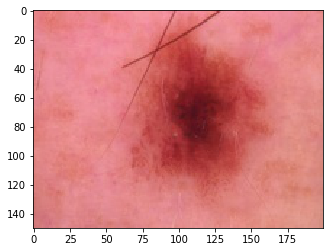

In [221]:
plt.imshow(images_rgb[0], cmap = 'gray')
#plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


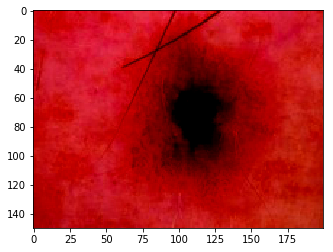

In [223]:
plt.imshow(norm_images_rgb[0], cmap = 'gray')
#plt.colorbar()
plt.show()

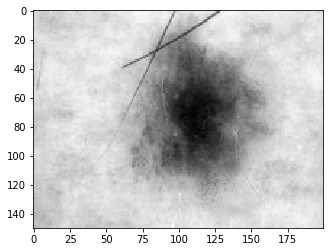

In [225]:
plt.imshow(images_gs[0], cmap = 'gray')
#plt.colorbar()
plt.show()

## 2.5 Data Matrix

In [252]:
images_gs.shape
DataMatrix = images_gs

DataMatrix=DataMatrix.reshape(7470, 150*200)
print(DataMatrix.shape)
DataMatrix=pd.DataFrame(DataMatrix)
#print(DataMatrix.head())
#print(filenames.head())
DataMatrix['image_ID'] = filenames
print(DataMatrix.head())

(7470, 30000)
          0         1         2         3         4         5         6  \
0  0.582258  0.598778  0.601561  0.587824  0.575754  0.579675  0.577138   
1  0.562695  0.566617  0.562695  0.566051  0.574728  0.570806  0.562963   
2  0.743484  0.739562  0.731719  0.731719  0.739562  0.745165  0.745165   
3  0.536681  0.544524  0.560210  0.547307  0.546741  0.554584  0.534976   
4  0.164479  0.160275  0.165305  0.159412  0.152945  0.157126  0.153205   

          7         8         9      ...          29991     29992     29993  \
0  0.573216  0.579660  0.588910      ...       0.647097  0.642602  0.634759   
1  0.565746  0.565746  0.569667      ...       0.601169  0.617994  0.606229   
2  0.737322  0.737322  0.730045      ...       0.663393  0.658378  0.658378   
3  0.520124  0.531888  0.531888      ...       0.521644  0.515200  0.519121   
4  0.141180  0.150170  0.129996      ...       0.235513  0.162729  0.156025   

      29994     29995     29996     29997     29998     2999

In [253]:
#save the data matrix
DataMatrix.to_csv('C:/Users/bella/OneDrive/Desktop/github_repositories/Classification_skinlesion_images_Py/DataMatrix.csv')
#images_gs = images_gs.reshape(7470, 150, 200, 1) #or without ,1
#images_rgb = images_rgb.reshape(7470, 150, 200, 3)
#norm_images_rgb = norm_images_rgb.reshape(7470, 150, 200, 3)

In [6]:
#DataMatrix 10015x30001, first column is the index
DataMatrix = pd.read_csv('C:/Users/bella/OneDrive/Desktop/github_repositories/Classification_skinlesion_images_Py/DataMatrix.csv', index_col=0)
DataMatrix.info()
#DataMatrix.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7470 entries, 0 to 7469
Columns: 30001 entries, 0 to image_ID
dtypes: float64(30000), object(1)
memory usage: 1.7+ GB


In [7]:
DataMatrix.head()
organized_metadata = pd.read_csv('C:/Users/bella/OneDrive/Desktop/github_repositories/Classification_skinlesion_images_Py/organized_metadata.csv', index_col=0)

print(organized_metadata.head())
print(metadata.head())

metadata.reset_index(level=0, inplace=True)
organized_metadata = pd.merge(left=filenames, right=metadata, left_on='filenames',right_on='image_id')

print(len(DataMatrix['image_ID'].unique()))
print(len(organized_metadata['image_id'].unique()))

      filenames    lesion_id   dx    dx_type   age     sex     localization
0  ISIC_0024306  HAM_0000550   nv  follow_up  45.0    male            trunk
1  ISIC_0024307  HAM_0003577   nv  follow_up  50.0    male  lower extremity
2  ISIC_0024308  HAM_0001477   nv  follow_up  55.0  female            trunk
3  ISIC_0024309  HAM_0000484   nv  follow_up  40.0    male            trunk
4  ISIC_0024310  HAM_0003350  mel      histo  60.0    male            chest
                lesion_id   dx dx_type   age   sex localization
image_id                                                       
ISIC_0027419  HAM_0000118  bkl   histo  80.0  male        scalp
ISIC_0025030  HAM_0000118  bkl   histo  80.0  male        scalp
ISIC_0026769  HAM_0002730  bkl   histo  80.0  male        scalp
ISIC_0025661  HAM_0002730  bkl   histo  80.0  male        scalp
ISIC_0031633  HAM_0001466  bkl   histo  75.0  male          ear
7470
7470


In [115]:
#merge the dataMatrix with metadata to get the other variables
#print(DataMatrix.imageID)
#print(metadatawithoutdup.image_id)
mergeDataMatrix=pd.merge( DataMatrix, organized_metadata, how='left', left_on="image_ID", right_on="image_id")

In [10]:
print(mergeDataMatrix.info())
print(mergeDataMatrix.head())

print(mergeDataMatrix.image_ID.isnull().sum())
print(mergeDataMatrix.image_id.isnull().sum()) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7470 entries, 0 to 7469
Columns: 30009 entries, 0 to localization
dtypes: float64(30001), object(8)
memory usage: 1.7+ GB
None
          0         1         2         3         4         5         6  \
0  0.582258  0.598778  0.601561  0.587824  0.575754  0.579675  0.577138   
1  0.562695  0.566617  0.562695  0.566051  0.574728  0.570806  0.562963   
2  0.743484  0.739562  0.731719  0.731719  0.739562  0.745165  0.745165   
3  0.536681  0.544524  0.560210  0.547307  0.546741  0.554584  0.534976   
4  0.164479  0.160275  0.165305  0.159412  0.152945  0.157126  0.153205   

          7         8         9       ...            29999      image_ID  \
0  0.573216  0.579660  0.588910       ...         0.603960  ISIC_0024306   
1  0.565746  0.565746  0.569667       ...         0.593631  ISIC_0024307   
2  0.737322  0.737322  0.730045       ...         0.627816  ISIC_0024308   
3  0.520124  0.531888  0.531888       ...         0.546327  ISIC_002

Although the main data are the images, it is possible to use as features also the personal information.

**Imputation of the missing data considering the classes.**

In [116]:
#print(mergeDataMatrix.age.isnull().sum()) #52
agemiss=mergeDataMatrix[mergeDataMatrix.age.isnull()] #to write the report
tab1=pd.crosstab(index=agemiss["dx"], columns="count")
tab1
#imputation of age by median of the lesions' type
print(mergeDataMatrix.groupby('dx')['age'].median()) 
for i in range(0,7469):  
    if(np.isnan(mergeDataMatrix.loc[i,'age'])):
        if mergeDataMatrix.loc[i,'age']=="akiec":
            mergeDataMatrix.loc[i,'age']=67.5 #maybe round it?
        elif mergeDataMatrix.loc[i,'age']=="bcc":
            mergeDataMatrix.loc[i,'age']=70.0
        elif mergeDataMatrix.loc[i,'age']=="bkl":
            mergeDataMatrix.loc[i,'age']=65.0
        elif mergeDataMatrix.loc[i,'age']=="df":
            mergeDataMatrix.loc[i,'age']=55.0
        elif mergeDataMatrix.loc[i,'age']=="mel":
            mergeDataMatrix.loc[i,'age']=65.0
        elif mergeDataMatrix.loc[i,'age']=="nv":
            mergeDataMatrix.loc[i,'age']=45.0
        else:
            mergeDataMatrix.loc[i,'age']=55.0

print(mergeDataMatrix.age.isnull().sum()) 
mergeDataMatrix.age=pd.to_numeric(mergeDataMatrix.age)

dx
akiec    67.5
bcc      70.0
bkl      65.0
df       55.0
mel      65.0
nv       45.0
vasc     55.0
Name: age, dtype: float64
0


In [117]:
#change unknown to male to not have a not frequent class
sex=pd.crosstab(organized_metadata.sex, organized_metadata.dx,margins=True)
print(sex)
count=0
for i in range(0,7469):  
    if(mergeDataMatrix.loc[i,'sex']=="unknown"):
        mergeDataMatrix.loc[i,'sex']="male" #because 9 bkl has the mode in male, 41 nv has the mode in male
        count=count+1        
print(count) #50 are the unknow

dx       akiec  bcc  bkl  df  mel    nv  vasc   All
sex                                                
female      80  122  304  38  243  2584    48  3419
male       148  205  414  35  371  2778    50  4001
unknown      0    0    9   0    0    41     0    50
All        228  327  727  73  614  5403    98  7470
50


In [128]:
#imputation of the localization
loc=pd.crosstab(organized_metadata.localization, organized_metadata.dx,margins=True)
print(loc)

count1=0
for i in range(0,7469):  
    if(mergeDataMatrix.loc[i, 'localization'] =="unknown"):
        if mergeDataMatrix.loc[i, 'dx']=="bcc":
            mergeDataMatrix.loc[i, 'localization']="back"
            count1=count1+1
        elif mergeDataMatrix.loc[i, 'dx']=="bkl":
            mergeDataMatrix.loc[i, 'localization']="face"
            count1=count1+1
        elif mergeDataMatrix.loc[i, 'dx']=="mel":
            mergeDataMatrix.loc[i, 'localization']="back"
            count1=count1+1   
        else:
            mergeDataMatrix.loc[i, 'localization']="lower extremity"
            count1=count1+1
        
print(count1) #203 missing values imputed, ok

mergeDataMatrix.localization[mergeDataMatrix.localization =="unknown"]="lower extremity"

loc=pd.crosstab(mergeDataMatrix.localization, mergeDataMatrix.dx,margins=True)
print(loc)

dx               akiec  bcc  bkl  df  mel    nv  vasc   All
localization                                               
abdomen              3    9   36   2   31   719    22   822
acral                0    0    0   0    0     3     0     3
back                22  123  133   1  185  1058    12  1534
chest                9   32   50   0   34   112     3   240
ear                  2    0    4   0   10    19     0    35
face                84   61  194   0   65    61     5   470
foot                 0    2    1   1   15   209     0   228
genital              0    0    1   1    0    43     0    45
hand                 8    1   12   0    1    39     3    64
lower extremity     41   36  109  54  104  1224    16  1584
neck                 8   11   20   0   18    60     2   119
scalp                8   11   24   0    9    24     2    78
trunk                1    6   57   0   25  1153    27  1269
unknown              0    3   19   0    6   175     0   203
upper extremity     42   32   67  14  11

C:\Users\bella\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
#transform the categorical variable in the appropriate type

#target
mergeDataMatrix['dxCat'] = pd.Categorical(mergeDataMatrix['dx'])

#localization
mergeDataMatrix['localizationCat']= pd.Categorical(mergeDataMatrix['localization'])

#sex
mergeDataMatrix['sexCat']= pd.Categorical(mergeDataMatrix['sex'])

In [292]:
print(mergeDataMatrix.info())
print(mergeDataMatrix.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7470 entries, 0 to 7469
Columns: 30012 entries, 0 to sexCat
dtypes: category(3), float64(30001), object(8)
memory usage: 1.7+ GB
None
          0         1         2         3         4         5         6  \
0  0.582258  0.598778  0.601561  0.587824  0.575754  0.579675  0.577138   
1  0.562695  0.566617  0.562695  0.566051  0.574728  0.570806  0.562963   
2  0.743484  0.739562  0.731719  0.731719  0.739562  0.745165  0.745165   
3  0.536681  0.544524  0.560210  0.547307  0.546741  0.554584  0.534976   
4  0.164479  0.160275  0.165305  0.159412  0.152945  0.157126  0.153205   

          7         8         9   ...        image_id    lesion_id   dx  \
0  0.573216  0.579660  0.588910   ...    ISIC_0024306  HAM_0000550   nv   
1  0.565746  0.565746  0.569667   ...    ISIC_0024307  HAM_0003577   nv   
2  0.737322  0.737322  0.730045   ...    ISIC_0024308  HAM_0001477   nv   
3  0.520124  0.531888  0.531888   ...    ISIC_0024309  HAM_000048

***

# 3. Supervised Learning Models


## 3.1 Random Forest

### Principal Component Analysis 1

In [16]:
onlynumerical_imag=mergeDataMatrix.drop(['lesion_id', 'image_id','dx','dx_type', 'age', 'sex', 'localization', 'image_ID', 'dxCat', 'localizationCat', 'sexCat', 'filenames'],axis=1)
print(onlynumerical_imag.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7470 entries, 0 to 7469
Columns: 30000 entries, 0 to 29999
dtypes: float64(30000)
memory usage: 1.7 GB
None


In [17]:
#standardizing
#scaling the 30 000 variables
# Standardizing the features
standard1=StandardScaler()
onlynumerical_imag_scaled = standard1.fit_transform(onlynumerical_imag)

In [18]:
pca1 = PCA()
PC = pca1.fit_transform(onlynumerical_imag_scaled)

In [19]:
print(pca1.explained_variance_ratio_)
c=pca1.explained_variance_ratio_
np.savetxt("explained_variance1.csv", c, delimiter=",")
print(pca1.singular_values_)
b=pca1.singular_values_
np.savetxt("singular_values1.csv", b, delimiter=",")
print(pca1.explained_variance_ratio_.cumsum())
a=pca1.explained_variance_ratio_.cumsum()
np.savetxt("explained_variance_cum1.csv", a, delimiter=",")
#162 variables to consider to have 95% of variance explained

[4.37900280e-01 1.59550297e-01 4.63524069e-02 ... 1.14768994e-07
 1.06051411e-07 2.13246309e-34]
[9.90623302e+03 5.97956700e+03 3.22297601e+03 ... 5.07146246e+00
 4.87505088e+00 2.18605805e-13]
[0.43790028 0.59745058 0.64380298 ... 0.99999989 1.         1.        ]


In [20]:
principalDf = pd.DataFrame(data = PC[:, 0:162])
principalDf.info()

locdumm = pd.get_dummies(mergeDataMatrix['localizationCat'],drop_first=True)
sexdumm= pd.get_dummies(mergeDataMatrix['sexCat'],drop_first=True)

#target= pd.get_dummies(mergeDataMatrix['dx']) #Not drop in the target case

finalDf = pd.concat([principalDf, mergeDataMatrix[['age']], locdumm, sexdumm], axis = 1)
print(finalDf.info())

y=mergeDataMatrix['dxCat']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7470 entries, 0 to 7469
Columns: 162 entries, 0 to 161
dtypes: float64(162)
memory usage: 9.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7470 entries, 0 to 7469
Columns: 178 entries, 0 to male
dtypes: float64(163), uint8(15)
memory usage: 9.4 MB
None


### Data Partition

In [21]:
# Spliting test set and training set
from sklearn.model_selection import train_test_split

data_train1, data_test1, label_train1, label_test1 = train_test_split(finalDf, y, test_size=0.10,random_state=1234, stratify=y)

### First try - default RF

In [22]:
#Random Forests
print('Training Features Shape:', data_train1.shape)
print('Training Labels Shape:', label_train1.shape)
print('Testing Features Shape:', data_test1.shape)
print('Testing Labels Shape:', label_test1.shape)

Training Features Shape: (6723, 178)
Training Labels Shape: (6723,)
Testing Features Shape: (747, 178)
Testing Labels Shape: (747,)


In [23]:
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 1234) #default
# Train the model on training data
rf.fit(data_train1, label_train1);

In [28]:
y_pred=rf.predict(data_test1)
#print(y_pred)
print(set(y_pred))

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(label_test1, y_pred)) #Accuracy: 0.7469879518072289, not a good measure when there are unbalanced datat

{'nv', 'mel', 'bkl'}
Accuracy: 0.7469879518072289


In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

print(pd.crosstab(label_test1, y_pred, rownames=['Actual'], colnames=['Predicted']))
#17/(17+1+55)
#5/(5+4+52)

Predicted  bkl  mel   nv
Actual                  
nv           1    3  536
mel          4    5   52
bcc          5    2   26
bkl         17    1   55
vasc         0    0   10
akiec        9    0   14
df           0    0    7


Only three predicted classes in the test set. Precision for the class bkl 23.28%. Precision for the class mel 8.19%.

### Undersampling

Undesampling the majority class randomly and try to balance the classes in the training set. 

Not consider "df" and "vasc" classes.

Test in the unbalanced scenario We don't know if this is a problem of data collection or if the "nv" class is more frequent comparing the other cases also in the reality, but we would like to know how the model behaviours in the unbalanced reality.

**Obs.** We tried to consider balanced training and balanced test and the model had this performance considering the test and 175 principal components. (Accuracy 94,32%) However, we are aware that these results are not replicable in the case the classes are not balanced.

Cross Validation's Accuracy:
* 1st Validation: 94,32%, 
* 2nd Validation: 94,05, 
* 3rd Validation 92,16% 

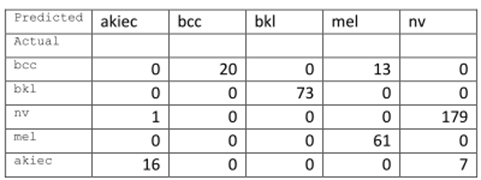


In [131]:
from sklearn.model_selection import train_test_split
y=mergeDataMatrix.dx
data_train1, data_test1, label_train1, label_test1 = train_test_split(mergeDataMatrix, y, test_size=0.20,random_state=1234, stratify=y)

In [137]:
#undersampling, easy way
print(pd.crosstab(data_train1.dx, "counts", normalize="all",margins=True))
temp=data_train1.loc[~data_train1['dx'].isin(['nv', 'df', 'vasc'])]
print(temp.info()) #1518 entries

col_0    counts       All
dx                       
akiec  0.030622  0.030622
bcc    0.043842  0.043842
bkl    0.097390  0.097390
df     0.009705  0.009705
mel    0.082162  0.082162
nv     0.723226  0.723226
vasc   0.013052  0.013052
All    1.000000  1.000000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1518 entries, 139 to 5150
Columns: 30009 entries, 0 to localization
dtypes: float64(30001), object(8)
memory usage: 347.6+ MB
None


In [138]:
nvclass=data_train1.loc[data_train1.dx=='nv']
print(nvclass.info()) #4322 entries
redct=4322/4
print(redct)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4322 entries, 2754 to 4989
Columns: 30009 entries, 0 to localization
dtypes: float64(30001), object(8)
memory usage: 989.6+ MB
None
1080.5


In [139]:
redct1=int(round(redct)) #need to be integer

from random import sample 
nvred=nvclass.sample(n=redct1)
print(nvred.info()) #1801

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1080 entries, 6048 to 1634
Columns: 30009 entries, 0 to localization
dtypes: float64(30001), object(8)
memory usage: 247.3+ MB
None


In [140]:
#concatenate with a random sample of the majority class with the minority classes considered
finalDfbalanced = pd.concat([temp, nvred], axis = 0)
print(finalDfbalanced.info()) #2598
pd.crosstab(finalDfbalanced.dx, "counts", normalize="all",margins=True) #majority class <50%

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2598 entries, 139 to 1634
Columns: 30009 entries, 0 to localization
dtypes: float64(30001), object(8)
memory usage: 594.8+ MB
None


col_0,counts,All
dx,,
akiec,0.070439,0.070439
bcc,0.100847,0.100847
bkl,0.224018,0.224018
mel,0.188992,0.188992
nv,0.415704,0.415704
All,1.000000,1.000000


### Principal Component Analysis 2

In [141]:
#shuffle the order
finalDfbalanced1=finalDfbalanced.sample(frac=1) #frac=1 
print(finalDfbalanced1.info()) #2598 entries

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2598 entries, 5205 to 1933
Columns: 30009 entries, 0 to localization
dtypes: float64(30001), object(8)
memory usage: 594.8+ MB
None


In [52]:
onlynumerical_imag1=finalDfbalanced1.drop(['lesion_id', 'image_id','dx','dx_type', 'age', 'sex', 'localization', 'image_ID', 'dxCat', 'localizationCat', 'sexCat','filenames'],axis=1)
print(onlynumerical_imag1.info())

#standardizing
standard2=StandardScaler()
# Standardizing the features
onlynumerical_imag_scaled1 = standard2.fit_transform(onlynumerical_imag1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2598 entries, 290 to 6622
Columns: 30000 entries, 0 to 29999
dtypes: float64(30000)
memory usage: 594.7 MB
None


In [87]:
pca2 = PCA(0.95) #to keep just the components that explain the 95% of the total variance
principalComponents1 = pca2.fit_transform(onlynumerical_imag_scaled1)
pca3 = PCA( n_components= 165)

In [54]:
print(principalComponents1.shape)

(2598, 165)


In [63]:
principalDf165 = pd.DataFrame(principalComponents1)
principalDf165.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2598 entries, 0 to 2597
Columns: 165 entries, 0 to 164
dtypes: float64(165)
memory usage: 3.3 MB


In [57]:
#Visualize one image before and after PCA
approximation = pca2.inverse_transform(principalDf165)

In [59]:
onlynumerical_imag1_imag = onlynumerical_imag1.values
onlynumerical_imag1_imag1=onlynumerical_imag1_imag.reshape(2598, 150, 200)
print(onlynumerical_imag1_imag.shape) #(2598, 30000)
print(onlynumerical_imag1_imag1.shape) #(2598, 150, 200)
#print(onlynumerical_imag1_imag)
print(approximation.shape)
approximation_image=approximation.reshape(2598, 150, 200)

(2598, 30000)
(2598, 150, 200)
(2598, 30000)


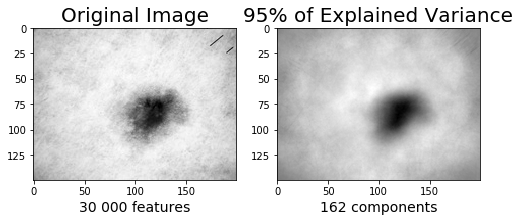

In [62]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4));

#plt.imshow(onlynumerical_imag1_imag[1], cmap = 'gray')
# Original Image
plt.subplot(1, 2, 1);
plt.imshow(onlynumerical_imag1_imag1[3],cmap = 'gray');
plt.xlabel('30 000 features', fontsize = 14)
plt.title('Original Image', fontsize = 20);

# 154 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation_image[3],cmap = 'gray');
plt.xlabel('162 components', fontsize = 14)
plt.title('95% of Explained Variance', fontsize = 20);

In [142]:
finalDfbalanced1['localizationCat']= pd.Categorical(finalDfbalanced1['localization'])
finalDfbalanced1['sexCat']= pd.Categorical(finalDfbalanced1['sex'])
finalDfbalanced1['dxCat']= pd.Categorical(finalDfbalanced1['dx'])

locdumm1 = pd.get_dummies(finalDfbalanced1['localizationCat'],drop_first=True)
sexdumm1= pd.get_dummies(finalDfbalanced1['sex'],drop_first=True)


finalDf = pd.concat([finalDfbalanced1['age'], locdumm1, sexdumm1], axis = 1)

finalDf.info()
finalDf=finalDf.reset_index()#otherwise doesn't work the concat properly
finalDf.info()

finalDf1 = pd.concat([finalDf, principalDf165], axis = 1)

print(finalDf1.info())
print(finalDf1.shape)

y=finalDfbalanced1['dxCat']
y.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2598 entries, 5205 to 1933
Data columns (total 14 columns):
age                2598 non-null float64
back               2598 non-null uint8
chest              2598 non-null uint8
ear                2598 non-null uint8
face               2598 non-null uint8
foot               2598 non-null uint8
genital            2598 non-null uint8
hand               2598 non-null uint8
lower extremity    2598 non-null uint8
neck               2598 non-null uint8
scalp              2598 non-null uint8
trunk              2598 non-null uint8
upper extremity    2598 non-null uint8
male               2598 non-null uint8
dtypes: float64(1), uint8(13)
memory usage: 73.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2598 entries, 0 to 2597
Data columns (total 15 columns):
index              2598 non-null int64
age                2598 non-null float64
back               2598 non-null uint8
chest              2598 non-null uint8
ear                2598 n

(2598,)

### Second try

In [68]:
#Random Forests
print('Training Features Shape:', finalDf1.shape)
print('Training Labels Shape:', y.shape)
print('Testing Features Shape:', data_test1.shape)
print('Testing Labels Shape:', label_test1.shape)

Training Features Shape: (2598, 181)
Training Labels Shape: (2598,)
Testing Features Shape: (1494, 30012)
Testing Labels Shape: (1494,)


In [143]:
rf2 = RandomForestClassifier(n_estimators = 1000, random_state = 1234) #always default
# Train the model on training data
rf2.fit(finalDf1, y);

In [97]:
#apply the same transformation of the training set in the test
onlynumerical_test1=data_test1.drop(['lesion_id', 'image_id','dx','dx_type', 'age', 'sex', 'localization', 'image_ID', 'dxCat', 'localizationCat', 'sexCat','filenames'],axis=1)
onlynumerical_test1.info()
#onlynumerical_test1.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1494 entries, 7410 to 5519
Columns: 30000 entries, 0 to 29999
dtypes: float64(30000)
memory usage: 342.0 MB


0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
        ..
29970    0
29971    0
29972    0
29973    0
29974    0
29975    0
29976    0
29977    0
29978    0
29979    0
29980    0
29981    0
29982    0
29983    0
29984    0
29985    0
29986    0
29987    0
29988    0
29989    0
29990    0
29991    0
29992    0
29993    0
29994    0
29995    0
29996    0
29997    0
29998    0
29999    0
Length: 30000, dtype: int64

In [98]:
data_test1_scaled1 = standard2.fit_transform(onlynumerical_test1)
data_test1_principalComponents1 = pca3.fit_transform(data_test1_scaled1)

In [101]:
locdumm1 = pd.get_dummies(data_test1['localizationCat'],drop_first=True)
sexdumm1= pd.get_dummies(data_test1['sex'],drop_first=True)

finaltest = pd.concat([data_test1['age'], locdumm1, sexdumm1], axis = 1)
#finaltest.isna().sum()

age                0
back               0
chest              0
ear                0
face               0
foot               0
genital            0
hand               0
lower extremity    0
neck               0
scalp              0
trunk              0
upper extremity    0
male               0
dtype: int64

In [102]:
finaltest=finaltest.reset_index()#otherwise doesn't work the concat properly
finaltest.info()
data_test1_principalComponents1=pd.DataFrame(data_test1_principalComponents1)
finaltest1 = pd.concat([finaltest, data_test1_principalComponents1], axis = 1)

finaltest1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494 entries, 0 to 1493
Data columns (total 15 columns):
index              1494 non-null int64
age                1494 non-null float64
back               1494 non-null uint8
chest              1494 non-null uint8
ear                1494 non-null uint8
face               1494 non-null uint8
foot               1494 non-null uint8
genital            1494 non-null uint8
hand               1494 non-null uint8
lower extremity    1494 non-null uint8
neck               1494 non-null uint8
scalp              1494 non-null uint8
trunk              1494 non-null uint8
upper extremity    1494 non-null uint8
male               1494 non-null uint8
dtypes: float64(1), int64(1), uint8(13)
memory usage: 42.4 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494 entries, 0 to 1493
Columns: 180 entries, index to 164
dtypes: float64(166), int64(1), uint8(13)
memory usage: 1.9 MB


In [144]:
#print(finaltest1.head())
#print(finalDf1.head())
#finaltest1.isna().sum()
print(finaltest1.columns.values)
print(finalDf1.columns.values)

['index' 'age' 'back' 'chest' 'ear' 'face' 'foot' 'genital' 'hand'
 'lower extremity' 'neck' 'scalp' 'trunk' 'upper extremity' 'male' 0 1 2 3
 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77
 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164]
['index' 'age' 'back' 'chest' 'ear' 'face' 'foot' 'genital' 'hand'
 'lower extremity' 'neck' 'scalp' 'trunk' 'upper extremity' 'male' 0 1 2 3
 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59 

In [145]:
y_pred=rf2.predict(finaltest1 )
#print(y_pred)
print(set(y_pred))

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(label_test1, y_pred)) #Accuracy: 0.7329317269076305

{'nv', 'mel', 'bkl'}
Accuracy: 0.7329317269076305


In [148]:
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

print(pd.crosstab(label_test1, y_pred, rownames=['Actual'], colnames=['Predicted']))

#56/(56+8+81)
#11/(11+24+88)

Predicted  bkl  mel    nv
Actual                   
akiec       20    0    25
bcc         20    3    42
bkl         56    8    81
df           1    0    14
mel         24   11    88
nv          40   13  1028
vasc         1    1    18


0.08943089430894309

Only three predicted classes in the test set, but considering that two classes are not possible to be predicted.
Precision for the class bkl 38.62% (before 23.28%). Precision for the class mel 8.94% (before 8.19%).

## 3.2 Neural Network

Without balancing the classes.
The parameters were chosen without any criteria (many possibilities to improve).

Grey scale images as input.

In [7]:
# Creating one-hot encoding manually (used in nn e cnn)
# Labels
labels = np.array(organized_metadata['dx'].tolist())
#print(type(labels))

# Classes
classes = np.array(["akiec","bcc","bkl","df","mel","nv","vasc"])
n_classes = len(classes)

# Initialize ohe_labels as all zeros
ohe_labels = np.zeros((len(labels), n_classes))

# Loop over the labels
for ii in range(len(labels)):
    # Find the location of this label in the categories variable
    jj = np.where(classes == labels[ii])
    # Set the corresponding zero to one
    ohe_labels[ii, jj] = 1
    
print(ohe_labels)

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [8]:
# Trying to create the first NN

# Imports components from Keras
from keras.models import Sequential
from keras.layers import Dense

# Initializes a sequential model
model = Sequential()

# First layer
model.add(Dense(10, activation='relu', input_shape=(30000,)))

# Second layer
model.add(Dense(10, activation='relu'))

# Third layer
model.add(Dense(10, activation='relu'))

# # Fourth layer
model.add(Dense(10, activation='relu'))

# Output layer
model.add(Dense(7, activation='softmax')) #multi-class

In [11]:
from sklearn.model_selection import train_test_split

data_train1, data_test1, label_train1, label_test1 = train_test_split(images_gs, ohe_labels, test_size=0.1,random_state=1234)

In [14]:
# Compile the model
model.compile(optimizer='adam',         
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

data_train1 = data_train1.reshape(len(data_train1),30000) #flat, grey scale

model.fit(data_train1, label_train1, 
          validation_split=0.2,
          epochs=3)

Train on 5378 samples, validate on 1345 samples
Epoch 1/3
5378/5378 [==============================] - 9s 2ms/step - loss: 0.9956 - acc: 0.7222 - val_loss: 1.0392 - val_acc: 0.7294
Epoch 2/3
5378/5378 [==============================] - 7s 1ms/step - loss: 0.9802 - acc: 0.7222 - val_loss: 0.9643 - val_acc: 0.7294
Epoch 3/3
5378/5378 [==============================] - 6s 1ms/step - loss: 0.9668 - acc: 0.7222 - val_loss: 0.9663 - val_acc: 0.7294


In [15]:
data_test1 = data_test1.reshape(len(data_test1), 30000)
y_pred=model.predict_classes(data_test1)
y_pred #Only one class predicted

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

## 3.3 Convolutional neural network


### First try

Without balancing the classes.
The parameters were chosen without any criteria (many possibilities to improve).
Using grey scale images.

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

model = Sequential()
model.add(Conv2D(10, kernel_size=3, activation='relu',  #10 the number of output filters in the convolution, 3 specifying the length of the 1D convolution window
              input_shape=(150, 200, 1)))#3 DIMENSIONS, 1 COLOR
model.add(Flatten())
model.add(Dense(7, activation='softmax'))

In [17]:
# Spliting test set and training set
from sklearn.model_selection import train_test_split

data_train1, data_test1, label_train1, label_test1 = train_test_split(images_gs, ohe_labels, test_size=0.10,random_state=1234)

In [22]:
data_train1.shape
data_train1=data_train1.reshape(6723, 150, 200,1)

In [24]:
# Fitting a CNN - with grayscale dataset
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(data_train1, label_train1, validation_split=0.2, epochs=3)


Train on 5378 samples, validate on 1345 samples
Epoch 1/3
5378/5378 [==============================] - 53s 10ms/step - loss: 4.4776 - acc: 0.7222 - val_loss: 4.3621 - val_acc: 0.7294
Epoch 2/3
5378/5378 [==============================] - 53s 10ms/step - loss: 4.4776 - acc: 0.7222 - val_loss: 4.3621 - val_acc: 0.7294
Epoch 3/3
5378/5378 [==============================] - 53s 10ms/step - loss: 4.4776 - acc: 0.7222 - val_loss: 4.3621 - val_acc: 0.7294


In [26]:
data_test1 = data_test1.reshape(len(data_test1),150, 200,1)

[test_loss, test_acc] = model.evaluate(data_test1, label_test1, verbose=0)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

y_pred=model.predict_classes(data_test1)
y_pred #Only one class predicted

Evaluation result on Test Data : Loss = 4.509614373147088, accuracy = 0.7202141899341241


array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

### Second try

Without balancing the classes.
The parameters were chosen without any criteria (many possibilities to improve).
Using rgb images.

In [27]:
# Implementing Image Convolutions in Keras -> For rgb images
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

model = Sequential()
model.add(Conv2D(10, kernel_size=3, activation='relu', 
              input_shape=(150, 200, 3))) #3DIMENSIONS, 3 COLOR

model.add(Flatten())
model.add(Dense(7, activation='softmax'))

In [28]:
# Spliting test set and training set
from sklearn.model_selection import train_test_split

data_train1, data_test1, label_train1, label_test1 = train_test_split(images_rgb, ohe_labels, test_size=0.10,random_state=1234)

In [29]:
# Fitting a CNN - with rgb dataset
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(data_train1, label_train1, validation_split=0.2, epochs=3)

Train on 5378 samples, validate on 1345 samples
Epoch 1/3
5378/5378 [==============================] - 90s 17ms/step - loss: 5.1930 - acc: 0.6778 - val_loss: 4.3621 - val_acc: 0.7294
Epoch 2/3
5378/5378 [==============================] - 90s 17ms/step - loss: 4.4776 - acc: 0.7222 - val_loss: 4.3621 - val_acc: 0.7294
Epoch 3/3
5378/5378 [==============================] - 89s 17ms/step - loss: 4.4776 - acc: 0.7222 - val_loss: 4.3621 - val_acc: 0.7294


In [30]:
[test_loss, test_acc] = model.evaluate(data_test1, label_test1, verbose=0)
# model.evaluate(data_test1, label_test1, epochs=3)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

y_pred=model.predict_classes(data_test1)
y_pred #Only one class predicted

Evaluation result on Test Data : Loss = 4.509614373147088, accuracy = 0.7202141899341241


array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

### Other experiments

Without balancing the classes. Using rgb images. The parameters were chosen without any criteria, but deep net.
Data Augmentation was applied too.

In [40]:
#In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

input_shape = (150, 200, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 150, 200, 32)      896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 150, 200, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 100, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 100, 32)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 75, 100, 64)       18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 75, 100, 64)       36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 50, 64)        0         
__________

In [42]:
# Compile the model
model.compile(optimizer = "Adam" , loss = "categorical_crossentropy", metrics=["accuracy"])

In [44]:
# With data augmentation to prevent overfitting 
data_train1, data_test1, label_train1, label_test1 = train_test_split(images_rgb, ohe_labels, test_size=0.10,random_state=1234)
data_train2, data_validate2, label_train2, label_validate2 = train_test_split(data_train1, label_train1, test_size = 0.2, random_state = 2)

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(data_train2)

In [47]:
# Fit the model
epochs = 3 
batch_size = 1
history = model.fit_generator(datagen.flow(data_train2,label_train2, batch_size=batch_size),
                              epochs = epochs, validation_data = (data_validate2,label_validate2),
                              verbose = 1, steps_per_epoch=data_train2.shape[0] // batch_size)

Epoch 1/3
5378/5378 [==============================] - 2156s 401ms/step - loss: 5.8589 - acc: 0.6365 - val_loss: 4.4460 - val_acc: 0.7242
Epoch 2/3
5378/5378 [==============================] - 2120s 394ms/step - loss: 5.1986 - acc: 0.6774 - val_loss: 4.4460 - val_acc: 0.7242
Epoch 3/3
5378/5378 [==============================] - 1834s 341ms/step - loss: 4.8252 - acc: 0.7006 - val_loss: 4.4460 - val_acc: 0.7242


In [49]:
# Model Evaluation
loss, accuracy = model.evaluate(data_validate2, label_validate2, verbose=1)
loss_v, accuracy_v = model.evaluate(data_test1, label_test1, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h4")

y_pred=model.predict_classes(data_test1)
y_pred #Only one class predicted and not the most frequent

747/747 [==============================] - 26s 34ms/step
Validation: accuracy = 0.720214  ;  loss_v = 4.509614
Test: accuracy = 0.724164  ;  loss = 4.445958


array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

### CNN with undersampling

Using the undersampling sample of random forest.

In [151]:
#trying the ccn
from keras.models import Sequential
from sklearn.model_selection import train_test_split
# ---
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
import keras
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D


input_shape = (150, 200, 1)
num_classes = 5

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 200, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 200, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 100, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 100, 32)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 100, 64)       18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 100, 64)       36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 50, 64)        0         
__________

In [152]:
# Compile the model
model.compile(optimizer = "Adam" , loss = "categorical_crossentropy", metrics=["accuracy"])

In [155]:
onlynumerical_imag1.shape
onlynumerical_imag1_imag1.shape

(2598, 150, 200)

In [157]:
onlynumerical_imag11=onlynumerical_imag1_imag1.reshape(2598, 150, 200, 1)
onlynumerical_imag11.shape
y.shape

y1=pd.get_dummies(y)
y1.shape

(2598, 5)

In [158]:
# With data augmentation to prevent overfitting 
data_train1, data_test1, label_train1, label_test1 = train_test_split(onlynumerical_imag11,y1, test_size=0.10,random_state=1234,  stratify=y)

data_train2, data_validate2, label_train2, label_validate2 = train_test_split(data_train1, label_train1, test_size = 0.2, random_state = 2)

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(data_train2)

In [160]:
# Fit the model
from functools import reduce

epochs = 5
batch_size = 2
history = model.fit_generator(datagen.flow(data_train2,label_train2, batch_size=batch_size),
                              epochs = epochs, validation_data = (data_validate2,label_validate2),
                              verbose = 1, steps_per_epoch=data_train2.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/5
935/935 [==============================] - 386s 412ms/step - loss: 1.4610 - acc: 0.4123 - val_loss: 1.4202 - val_acc: 0.4316
Epoch 2/5
935/935 [==============================] - 378s 404ms/step - loss: 1.4525 - acc: 0.4112 - val_loss: 1.4368 - val_acc: 0.4316
Epoch 3/5
935/935 [==============================] - 376s 402ms/step - loss: 1.4572 - acc: 0.4118 - val_loss: 1.4306 - val_acc: 0.4316
Epoch 4/5
935/935 [==============================] - 375s 401ms/step - loss: 1.4520 - acc: 0.4118 - val_loss: 1.4175 - val_acc: 0.4316

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 5/5
935/935 [==============================] - 374s 400ms/step - loss: 1.4453 - acc: 0.4118 - val_loss: 1.4298 - val_acc: 0.4316


**Old try** different parameters
 
Epoch 1/3
2661/2661 [==============================] - 1076s 404ms/step - loss: 1.4050 - acc: 0.4821 - val_loss: 1.3579 - val_acc: 0.4910

Epoch 2/3
2661/2661 [==============================] - 1068s 401ms/step - loss: 1.3802 - acc: 0.4863 - val_loss: 1.3567 - val_acc: 0.4910

Epoch 3/3
2661/2661 [==============================] - 1018s 383ms/step - loss: 1.3643 - acc: 0.4863 - val_loss: 1.3583 - val_acc: 0.4910


In [161]:
# Model Evaluation
loss, accuracy = model.evaluate(data_validate2, label_validate2, verbose=1)
loss_v, accuracy_v = model.evaluate(data_test1, label_test1, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

260/260 [==============================] - 13s 49ms/step
Validation: accuracy = 0.415385  ;  loss_v = 1.442760
Test: accuracy = 0.431624  ;  loss = 1.429766


**Old try** different parameters

666/666 [==============================] - 31s 47ms/step

370/370 [==============================] - 17s 46ms/step

Validation: accuracy = 0.486486  ;  loss_v = 1.357561

Test: accuracy = 0.490991  ;  loss = 1.358307

In [198]:
y_pred=model.predict_classes(data_test1)
#print(pd.crosstab(label_test1, y_pred, rownames=['Actual'], colnames=['Predicted'])) 
y_pred  #Only one class predicted
#label_test1

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int64)

***

## 5. Conclusions

Because of the complexity of the problems, many other techniques could be explored. 

We think that a better image pre-processing could make the prediction improves: considering, for example, the spatial correlation, the reduction of the space by pixel positions, some filters of the image’s noises and many other treatments. 

Moreover, it would be possible to explore and test better different undersampling/oversampling techniques and maybe, also ensemble different models with different datasets to have a more stable classification in the validation. 

Additionally, many parameters could be tested and tuned to better personalize the model but always considering a good trade-off between the goodness of the model and the ability of generalization. 

In conclusion, also considering the respective probabilities of the image to belong to the seven classes could be more useful.